In [3]:
# Author: Riley Owens (GitHub: mrileyowens)

# This file measures values and errors of 
# various Lyα profile parameters.

In [37]:
import os
import glob

from math import floor, log10

from datetime import datetime, timezone

import numpy as np

import pandas as pd

from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.stats import kendalltau, spearmanr

import sigfig
from sigfig import round as sf_round
#from to_precision import std_notation
import decimal

from astropy.cosmology import FlatLambdaCDM

from numba import njit

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib import gridspec

In [44]:
def fit():

    def extract_data(file):

        '''
        Extract spectrum from the .txt file

        Parameters:
            file : str
                Name of the file

        Returns:
            w : numpy.ndarray
                Observed wavelength bins
            f : numpy.ndarray
                Observed flux densities
            n : numpy.ndarray
                Observed Gaussian standard deviation of observed flux densities
        '''

        # Retrieve the data columns
        w, f, n = np.loadtxt(file, delimiter='\t', comments=('#', 'w'), usecols=(0,1,2), unpack=True)
    
        # If the file is not the stacked leaker spectrum. This step is necessary because 
        if 'leaker' not in file:

            # Remove bins of extreme outliers
            w = w[f < 1e-20]
            n = n[f < 1e-20]
            f = f[f < 1e-20]

            # Convert from units of erg/s/cm^2/Hz to erg/s/cm^2/Å
            f = f * 2.998e18 / np.square(w)
            n = n * 2.998e18 / np.square(w)

        return w, f, n    

    def compute_fwhm_and_peak(parameters, Rs):

        '''
        Returns:
            fwhm : numpy.float64
            loc : numpy.float64
        '''
        def lin_interp(x, y, i):
            return x[i] + (x[i+1] - x[i]) * y[i] / (y[i+1] - y[i])

        def skew_gaussian(x, amp, cen, width, skew):

            fit = amp * np.exp(-((x - cen) / width)**2 / 2) * (1 + erf(skew * ((x - cen) / width) / np.sqrt(2)))

            return fit

        v = np.arange(-500,500,0.1)

        fits = []

        for i, fit_params in enumerate(parameters):

            fit = skew_gaussian(v, *fit_params)

            fits.append([*fit])

        fits_max_indices = np.argmax(fits, axis=1)

        locs = v[fits_max_indices]

        fits_halved = fits - np.amax(fits, axis=1, keepdims=True) / 2

        crossings = np.diff(np.sign(fits_halved), axis=1) != 0

        indices = np.array(np.where(crossings))

        indices = indices.T

        fwhms = []

        for i in range(len(parameters)):

            fwhm = abs(lin_interp(v, fits_halved[i], indices[2 * i][1]) - lin_interp(v, fits_halved[i], indices[2 * i + 1][1]))

            fwhms.append(fwhm)

        #res = np.random.normal(R, R_error, len(parameters))

        fwhms = np.sqrt((np.array(fwhms))**2 - (Rs)**2)
        fwhms = np.where(np.isnan(fwhms), Rs, fwhms)

        return fwhms, locs

    def two_peaks(x, amp_r, cen_r, width_r, skew_r, amp_c, cen_c, width_c, cntm):

        return amp_r * np.exp(-((x - cen_r) / width_r)**2 / 2) * (1 + erf(skew_r * ((x - cen_r) / width_r) / np.sqrt(2))) \
            + amp_c * np.exp(-((x - cen_c) / width_c)**2 / 2) \
            + cntm

    def three_peaks(x, amp_b, cen_b, width_b, skew_b, amp_r, cen_r, width_r, skew_r, amp_c, cen_c, width_c, cntm):

        return amp_b * np.exp(-((x - cen_b) / width_b)**2 / 2) * (1 + erf(skew_b * ((x - cen_b) / width_b) / np.sqrt(2)))  \
            + amp_r * np.exp(-((x - cen_r) / width_r)**2 / 2) * (1 + erf(skew_r * ((x - cen_r) / width_r) / np.sqrt(2))) \
            + amp_c * np.exp(-((x - cen_c) / width_c)**2 / 2) \
            + cntm

    # Dictionary containing information about the MagE slit spectra, including, from left to right:
    # the name of the file containing the data, redshift (taken from Mainali et al. (2022) (ApJ, 940, 160)),
    # magnification of the slit, a tuple specifying a range of Lya peculiar velocities used to set 
    # initial parameter estimates of the central Lya peak, spectral resolution, and uncertainty in the spectral resolution
    slits = {
        'NL' : ['rest_sba-nonleaker-no_m3_MWdr.txt', 0, 1, [60,140], 5400, 200],
        'L' : ['rest_sba-leaker-no_m0_MWdr.txt', 0, 1, [20,130], 5300, 200],
        'M5' : ['psz-arcslit-m5-comb1_MWdr.txt', 2.37086, 51, [0,100], 5500, 400],
        'M4' : ['psz-arcslit-m4-comb1_MWdr.txt', 2.37073, 14.6, [0,85], 5400, 300],
        'M6' : ['psz-arcslit-m6-comb1_MWdr.txt', 2.37021, 147, [10,130], 5300, 300],
        'M3' : ['psz-arcslit-m3-comb1_MWdr.txt', 2.37025, 36, [35,120], 5500, 400],
        'M0' : ['planckarc_m0-comb1_MWdr.txt', 2.37014, 10, [10,130], 4700, 200],
        'M2' : ['psz-arcslit-m2-comb1_MWdr.txt', 2.37017, 32, [45,125], 5300, 300],
        'M7' : ['psz-arcslit-m7-comb1_MWdr.txt', 2.37044, 35, [15,100], 5200, 200],
        'M8' : ['psz-arcslit-m8-comb1_MWdr.txt', 2.37024, 29, [25,125], 5200, 300],
        'M9' : ['psz-arcslit-m9-comb1_MWdr.txt', 2.37030, 31, [15,125], 5500, 400]
    }

    # Establish directories
    home = os.getcwd()
    data = f'{home}/data'
    results = f'{home}/results'

    #f_esc = [2.3, -0.6, 3, 2.3, 17, 18, 12, 15, 14]
    #ne_esc = [0.8, 0.2, 1, 0.8, 6, 7, 5, 6, 5]

    #c_peak_range = np.array([[60,140],[20,130],[0,100],[0,85],[10,130],[35,120],[10,130],
    #                         [45,125],[15,100],[25,125],[15,125]], dtype=np.float64)

    #total_result = np.array([np.empty((9,1000))])

    '''
    R = np.array([
        299792.458 / 5400,
        299792.458 / 5300,
        299792.458 / 5500,
        299792.458 / 5400,
        299792.458 / 5300,
        299792.458 / 5500,
        299792.458 / 4700,
        299792.458 / 5300,
        299792.458 / 5200,
        299792.458 / 5200,
        299792.458 / 5500
    ])

    R_error = np.array([
        299792.458 / 5400**2 * 200,
        299792.458 / 5300**2 * 200,
        299792.458 / 5500**2 * 400,
        299792.458 / 5400**2 * 300,
        299792.458 / 5300**2 * 300,
        299792.458 / 5500**2 * 400,
        299792.458 / 4700**2 * 200,
        299792.458 / 5300**2 * 300,
        299792.458 / 5200**2 * 200,
        299792.458 / 5200**2 * 300,
        299792.458 / 5500**2 * 400
    ])
    '''

    # Instantiate a cosmology with 30% matter-based energy density and an expansion rate of 70 km/s/Mpc
    cosmology = FlatLambdaCDM(70,0.3)

    # For each slit ID
    for i, slit_id in enumerate(slits):

        # Unpack the dictionary values for this slit
        file_name, z, mag, c_peak_range, R, R_error = slits[slit_id]

        # Convert the spectral resolution to units of km/s, which is 
        # necessary when correcting the FWHMs (which has units of km/s)
        # for the instrumental resolution
        R_error = 299792.458 / R**2 * R_error
        R = 299792.458 / R

        '''
        mag = slits[slit_id][2]
        c_peak_range = slits[slit_id][3]
        R = slits[slit_id][4]
        R_error = slits[slit_id][5]
        '''

        # Set a scaling factor which will be applied to the data. This is necesary
        # because for the observed data (so not the stacked spectra), the fits are 
        # very poor (the fitting does not explore the parameter space) without rescaling 
        # them, perhaps related to float precision because given their flux density units, 
        # the flux density values are very small (~10^16 - 10^17 erg/s/cm^2/Å)
        factor = 1e16 if 'M' in slit_id else 1

        # Extract the data from the .txt file
        w, f, n = extract_data(f'{data}/spectra/mage/{file_name}')

        # Cut the data to just the relevant portion of the spectrum
        f = f[(w >= 1195 * (1 + z)) & (w <= 1235 * (1 + z))]
        n = n[(w >= 1195 * (1 + z)) & (w <= 1235 * (1 + z))]
        w = w[(w >= 1195 * (1 + z)) & (w <= 1235 * (1 + z))]
        
        # Place the data in the rest frame, and apply the scaling factor
        w = w / (1 + z)
        f = f * (1 + z) * factor
        n = n * (1 + z) * factor

        # Calculate the Lya peculiar velocities
        v = 299792.458 * (w / 1215.67 - 1)

        # Instantiate a cosmology with 30% matter-based energy density and an expansion rate of 70 km/s/Mpc
        #cosmology = FlatLambdaCDM(70,0.3)

        # Determine the luminosity distance to the redshift in units of centimeters (to match the flux density unit)
        l_dist = cosmology.luminosity_distance(z).value * 3.086e24

        # Create a boolean mask designating the wavelength range used to compute the local continuum
        cntm_mask = (w >= 1221) & (w <= 1225)

        # Create a boolean mask designating the integration range when computing the equivalent width
        #ew_mask = (w >= 1212) & (w <= 1221)

        # Create a boolean mask designating the integration range when computing the Lya equivalent width and luminosity
        lya_profile_mask = (w >= 1212) & (w <= 1221)
        
        # Create boolean masks for the integration ranges about the rest velocity of the Lya profile
        # for computing the central escape fraction of the Lya profile
        v100_mask = (v >= -100) & (v <= 100)
        v1000_mask = (v >= -1000) & (v <= 1000)

        # Mask for the observed-frame wavelength boundaries when computing the luminosity of the Lya profile
        #l_mask = (w * (1 + z) >= 1212 * (1 + z)) & (w * (1 + z) <= 1221 * (1 + z))

        # Set a string for the flux density unit of the data
        flux_density_unit = 'erg/s/cm^2/Å' if 'M' in slit_id else 'normalized wavelength-space flux density'

        # If there is no blue peak and the slit ID is not M5
        if i in [0,3,4]:
        
            # Set the model function and the model parameter labels
            model = two_peaks
            model_parameter_labels = f'redshifted Lyα peak amplitude ({flux_density_unit}), centroid (km/s), width (km/s), and skew, \n' \
                + f'central Lyα peak amplitude ({flux_density_unit}), centroid (km/s), and width (km/s), ' \
                + f'and local continuum ({flux_density_unit})'
        
            # Set the initial parameter estimates and bounds
            p0 = (np.amax(f[(v >= 150) & (v <= 1000)]),200,20,1,np.amax(f[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]),80,40,np.median(f[cntm_mask]))
            bounds = ([0,0,0,0,0,0,0,0],[np.amax(f),1000,np.inf,np.inf,np.amax(f),200,85,np.amax(f)])
    
        # If the slit ID is M5; this elif statement is necessary for improved initial parameter estimates of the central Lya peak in slit M5. The previous
        # if statement was not satisfactory
        elif i in [2]:

            # Set the model function and the model parameter labels
            model = two_peaks
            model_parameter_labels = f'redshifted Lyα peak amplitude ({flux_density_unit}), centroid (km/s), width (km/s), and skew, \n' \
                + f'central Lyα peak amplitude ({flux_density_unit}), centroid (km/s), and width (km/s), ' \
                + f'and local continuum ({flux_density_unit})'

            # Set the initial parameter estimates and bounds
            p0 = (np.amax(f[(v >= 150) & (v <= 1000)]),200,20,1,np.amax(f[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]) - np.median(f[cntm_mask]),50,20,np.median(f[cntm_mask]))
            bounds = ([0,0,0,0,0,0,0,0],[np.amax(f),500,np.inf,np.inf,np.amax(f[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]) - np.median(f[cntm_mask]),100,40,np.amax(f)])

        # Otherwise
        else:

            # Set the model function and the model parameter labels
            model = three_peaks
            model_parameter_labels = f'blueshifted Lyα peak amplitude ({flux_density_unit}), centroid (km/s), width (km/s), and skew, \n' \
                + f'redshifted Lyα peak amplitude ({flux_density_unit}), centroid (km/s), width (km/s), and skew, \n' \
                + f'central Lyα peak amplitude ({flux_density_unit}), centroid (km/s), and width (km/s), ' \
                + f'and local continuum ({flux_density_unit})'

            # Set the initial parameter estimates and bounds
            p0 = (np.amax(f[(v >= -1000) & (v <= 0)]),-150,20,-1,np.amax(f[(v >= 150) & (v <= 1000)]),200,20,1,np.amax(f[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]),80,40,np.median(f[cntm_mask]))
            bounds = ([0,-1000,0,-np.inf,0,0,0,0,0,0,0,0],[np.amax(f[(v >= -1000) & (v <= 0)]),0,np.inf,0,np.amax(f),1000,np.inf,np.inf,np.amax(f),200,85,np.amax(f)])

        # Establish empty lists to append the results of the burn-in Monte Carlo simulation to
        mc_spectra_burn_in = []
        parameters_burn_in = []

        # For each iteration in the burn-in Monte Carlo simulation
        for j in range(1000):

            # Draw a randomly sampled spectrum from the original observation, assuming 
            # that the observed flux densities and associated uncertainties correspond 
            # to the mean and standard deviation of Gaussian distributions, respectively
            f_mc = np.random.normal(f, n)

            # Directly fit the Lya profile with the assigned model function and initial parameter estimates and bounds
            p, _ = curve_fit(model, v[v >= -500], f_mc[v >= -500], p0=p0, bounds=bounds, maxfev=1e6) 

            # Append the randomly sampled spectrum and best-fit model parameters to the aggregate lists
            mc_spectra_burn_in.append([*f_mc])
            parameters_burn_in.append([*p])

        mc_spectra_burn_in = np.array(mc_spectra_burn_in, dtype=np.float64)

        p0 = np.array(p0, dtype=np.float64)
        parameters_burn_in = np.array(parameters_burn_in, dtype=np.float64)

        # Unscale the affected intial model parameter estimates by the artificial scale factor
        p0[-1], p0[-4], p0[-8] = p0[-1] / factor, p0[-4] / factor, p0[-8] / factor

        # Also unscale the initial estimate of the amplitude of the blueshifted Lya peak if the model function had 3 peaks
        p0[0] = p0[0] / factor if model==three_peaks else p0[0]

        # Set the header for the output file containing the randomly sampled Lya spectra of the burn-in Monte Carlo simulation
        header = f'Randomly sampled Lyα spectra of the burn-in Monte Carlo simulation of {f"slit {slit_id}" if "M" in slit_id else slit_id}.\n' \
            + f'Created by lya.ipynb on {datetime.now(timezone.utc).isoformat().replace("+00:00", "Z")}.\n' \
            + '\n' \
            + f'Number of iterations of the burn-in Monte Carlo simulation: {len(mc_spectra_burn_in)}\n' \
            + '\n' \
            + f'Columns, from left to right: peculiar velocity relative to Lyα (km/s), flux density uncertainty ({flux_density_unit}), and randomly sampled flux densities of each iteration of the Monte Carlo simulation ({flux_density_unit})\n'

        # Save the output file containing the randomly sampled Lya spectra of the burn-in Monte Carlo simulation
        np.savetxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_burn_in_lya_spectra.txt', np.array([v, n / factor, *(mc_spectra_burn_in / factor)]).T, header=header, delimiter=' ', encoding='utf-8')

        # Set the header for the output file containing the best-fit model parameters of the burn-in Monte Carlo simulation
        header = f'Best-fit model parameters of the Lyα fits of the burn-in Monte Carlo simulation of {f"slit {slit_id}" if "M" in slit_id else slit_id}.\n' \
            + f'Created by lya.ipynb on {datetime.now(timezone.utc).isoformat().replace("+00:00", "Z")}.\n' \
            + '\n' \
            + f'Initial parameters used by the burn-in Monte Carlo simulation: {p0}\n' \
            + f'Number of iterations of the burn-in Monte Carlo simulation: {len(mc_spectra_burn_in)}\n' \
            + '\n' \
            + f'Columns, from left to right: {model_parameter_labels}\n'
        
        p0_burn_in_save = parameters_burn_in.copy()
        
        # Unscale the affected intial model parameter estimates by the artificial scale factor
        p0_burn_in_save[:,-1], p0_burn_in_save[:,-4], p0_burn_in_save[:,-8] = p0_burn_in_save[:,-1] / factor, p0_burn_in_save[:,-4] / factor, p0_burn_in_save[:,-8] / factor

        # Also unscale the initial estimate of the amplitude of the blueshifted Lya peak if the model function had 3 peaks
        p0_burn_in_save[:,0] = p0_burn_in_save[:,0] / factor if model==three_peaks else p0_burn_in_save[:,0]

        # Save the output file containing the best-fit model parameters
        np.savetxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_burn_in_lya_best_fit_model_parameters.txt', p0_burn_in_save, header=header, delimiter=' ', encoding='utf-8')

        # Compute the median best-fit model parameters of the burn-in Monte Carlo simulation
        p0_burn_in = np.median(np.array(parameters_burn_in, dtype=np.float64).T, axis=1)

        # Establish empty lists to append the results of the Monte Carlo simulation to
        mc_spectra = []
        parameters = []
        measurements = []

        # For each iteration in the Monte Carlo simulation
        for j in range(10000):

            # Draw a randomly sampled spectrum from the original observation, assuming 
            # that the observed flux densities and associated uncertainties correspond 
            # to the mean and standard deviation of Gaussian distributions, respectively
            f_mc = np.random.normal(f, n)

            # Compute the local continuum as the median flux density between 1221 - 1225 Å in the rest frame
            c = np.median(f_mc[cntm_mask])

            # Compute the rest-frame equivalent width of the Lya profile
            ew = -1 * np.trapz(1 - (f_mc / c)[lya_profile_mask], w[lya_profile_mask])

            # Compute the central escape fraction of the Lya profile
            f_cen = np.trapz(f_mc[v100_mask], v[v100_mask]) / np.trapz(f_mc[v1000_mask], v[v1000_mask]) * 100

            # Compute the luminosity of the Lya profile, placing the data back into the observed frame, removing the scaling factor, and 
            # correcting for the magnification
            #l = 4 * np.pi * np.trapz((f_mc / (1 + z) / mag)[l_mask] - c / (1 + z) / mag, (w * (1 + z))[l_mask]) * l_dist**2
            l = 4 * np.pi * np.trapz((f_mc[lya_profile_mask] - c) / (1 + z) / mag / factor, (w * (1 + z))[lya_profile_mask]) * l_dist**2

            # Directly fit the Lya profile with the assigned model function and initial parameter estimates and bounds
            p, _ = curve_fit(model, v[(v >= -500) & (f_mc >= c)], f_mc[(v >= -500) & (f_mc >= c)], p0=p0_burn_in, bounds=bounds, maxfev=1e6) 

            # Compute the ratio between the 'minimum' flux density between the redshifted and blueshifted Lya peaks 
            # (really taken as the amplitude of the central Lya peak; see paper for justifying details) and the local continuum
            ratio = p[-4] / p[-1]

            # Append the randomly sampled spectrum, best-fit model parameters, and Lya measurements to the aggregate lists
            mc_spectra.append([*f_mc])
            parameters.append([*p])
            measurements.append([ratio, ew, f_cen, l])

        # Convert all of the result lists into arrays for easier handling
        #p0 = np.array(p0, dtype=np.float64)
        mc_spectra = np.array(mc_spectra, dtype=np.float64)
        parameters = np.array(parameters, dtype=np.float64)
        measurements = np.array(measurements, dtype=np.float64)

        # Unscale the affected best-fit model parameters by the artifical scaling factor
        p0_burn_in[-1], p0_burn_in[-4], p0_burn_in[-8] = p0_burn_in[-1] / factor, p0_burn_in[-4] / factor, p0_burn_in[-8] / factor

        # Also unscale the amplitude of the blueshifted Lya peak if the model function had 3 peaks
        p0_burn_in[0] = p0_burn_in[0] / factor if model==three_peaks else p0_burn_in[0]

        # Unscale the affected best-fit model parameters by the artifical scaling factor
        parameters[:,-1], parameters[:,-4], parameters[:,-8] = parameters[:,-1] / factor, parameters[:,-4] / factor, parameters[:,-8] / factor

        # Also unscale the amplitude of the blueshifted Lya peak if the model function had 3 peaks
        parameters[:,0] = parameters[:,0] / factor if model==three_peaks else parameters[:,0]

        # Unscale the affected intial model parameter estimates by the artificial scale factor
        #p0[-1], p0[-4], p0[-8] = p0[-1] / factor, p0[-4] / factor, p0[-8] / factor

        # Also unscale the initial estimate of the amplitude of the blueshifted Lya peak if the model function had 3 peaks
        #p0[0] = p0[0] / factor if model==three_peaks else p0[0]

        measurements[:,-1] = np.nan if 'L' in slit_id else measurements[:,-1]

        # Randomly sample spectral resolutions for the spectrum from a Gaussian distribution, 
        # matching the number of iterations of the Monte Carlo simulation, and assuming that 
        # the reported measurement and uncertainty correspond to the mean and standard deviation 
        # of the Gaussian distribution. This is necessary to fold in the uncertainty in the 
        # spectral resolution into the measured FWHMs of the Lya peaks, since they are corrected
        # for instrumental resolution
        Rs = np.random.normal(R, R_error, len(parameters))

        # Calculate the FWHMs of the central Lya peak, correcting for the instrumental resolution
        fwhms_c = 2 * np.sqrt(2 * np.log(2)) * parameters.T[-2]
        fwhms_c = np.sqrt((np.array(fwhms_c))**2 - (Rs)**2)

        fwhms_c = np.where(np.isnan(fwhms_c), Rs, fwhms_c)

        # Calculate the FWHMs and locations of the maxima of the redshifted Lya peak
        fwhms_r, locs_r = compute_fwhm_and_peak(parameters[:, -8:-4], Rs)

        # Insert the central and redshifted Lya peak FWHMs into the Lya measurements array
        measurements = np.insert(measurements, 0, fwhms_r, axis=1)
        measurements = np.insert(measurements, 0, fwhms_c, axis=1)

        # Instantiate the Lya peak separations and blueshifted Lya peak FWHMs as NaNs. This is
        # done to keep the output Lya measurements the same shape for all the spectra, even if
        # they do not have a blueshifted Lya peak necessary to measure the Lya peak separation
        # and blueshifted Lya peak FWHM. If the spectrum does have a third peak, these NaNs
        # will be replaced by actual measurements in the following if statement
        v_sep, fwhms_b = np.empty(len(mc_spectra)), np.empty(len(mc_spectra))
        v_sep[:], fwhms_b[:] = np.nan, np.nan

        # If the spectrum has three Lya peaks
        if slit_id in ['L', 'M0', 'M2', 'M3', 'M7', 'M8', 'M9']:
            
            # Calculate the FWHMs and locations of the maxima of the blueshifted Lya peak
            fwhms_b, locs_b = compute_fwhm_and_peak(parameters[:, 0:4], Rs)

            # Calculate the Lya peak separations
            v_sep = np.abs(locs_r - locs_b)

        # Insert the Lya peak separations and blueshifted Lya peak FWHMs into the Lya measurements array
        measurements = np.insert(measurements, 0, [v_sep, fwhms_b], axis=1)

        # Insert the randomly sampled spectral resolutions into the Lya measurements array, since they are 
        # necessary to measure the instrument-corrected FWHMs
        measurements = np.insert(measurements, 0, 299792.458 / Rs, axis=1)

        # If the results folder for this slit ID doesn't exist yet, make it
        if not os.path.isdir(f'{results}/lya_fits/{slit_id}'):
            os.makedirs(f'{results}/lya_fits/{slit_id}')

        # Set the header for the output file containing the randomly sampled Lya spectra
        header = f'Randomly sampled Lyα spectra of the Monte Carlo simulation of {f"slit {slit_id}" if "M" in slit_id else slit_id}\n' \
            + f'Created by lya.ipynb on {datetime.now(timezone.utc).isoformat().replace("+00:00", "Z")}.\n' \
            + '\n' \
            + f'Number of iterations of this Monte Carlo simulation: {len(mc_spectra)}\n' \
            + '\n' \
            + f'Columns, from left to right: peculiar velocity relative to Lyα (km/s), flux density uncertainty ({flux_density_unit}), and randomly sampled flux densities of each iteration of the Monte Carlo simulation ({flux_density_unit})\n'

        # Save the output file containing the randomly sampled Lya spectra
        np.savetxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_lya_spectra.txt', np.array([v, n / factor, *(mc_spectra / factor)]).T, header=header, delimiter=' ', encoding='utf-8')    

        # Set the header for the output file containing the best-fit model parameters
        header = f'Best-fit model parameters of the Lyα fits of the Monte Carlo simulation of {f"slit {slit_id}" if "M" in slit_id else slit_id}.\n' \
            + f'Created by lya.ipynb on {datetime.now(timezone.utc).isoformat().replace("+00:00", "Z")}.\n' \
            + '\n' \
            + f'Initial parameters from the burn-in Monte Carlo simulation: {p0_burn_in}\n' \
            + f'Number of iterations of this Monte Carlo simulation: {len(mc_spectra)}\n' \
            + '\n' \
            + f'Columns, from left to right: {model_parameter_labels}\n'

        # Save the output file containing the best-fit model parameters
        np.savetxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_lya_best_fit_model_parameters.txt', parameters, header=header, delimiter=' ', encoding='utf-8')

        # Set the header for the output file containing the Lya measurements
        header = f'Measurements of the Lyα profiles from the best-fit curves of the Monte Carlo simulation of {f"slit {slit_id}" if "M" in slit_id else slit_id}\n' \
            + f'Created by lya.ipynb on {datetime.now(timezone.utc).isoformat().replace("+00:00", "Z")}.\n' \
            + '\n' \
            + f'Number of iterations of this Monte Carlo simulation: {len(mc_spectra)}\n' \
            + '\n' \
            + 'Columns, from left to right: spectral resolution (R), Lyα peak separation (km/s), blueshifted Lyα peak FWHM (km/s), central Lyα peak FWHM (km/s), redshifted Lyα peak FWHM (km/s),\n' \
            + 'ratio between the \'minimum\' flux density between the redshifted and blueshifted Lyα peaks and the continuum flux density (consult the paper for more details),\n' \
            + 'rest-frame Lyα equivalent width (Å), central fraction of Lyα flux (%), and Lyα luminosity (erg/s)\n'

        # Save the output file containing the Lya measurements
        np.savetxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_lya_measurements.txt', measurements, header=header, delimiter=' ', encoding='utf-8')

def correlate():

    slits = {
        'NL' : ['rest_sba-nonleaker-no_m3_MWdr.txt', 0, 1, [60,140]],
        'L' : ['rest_sba-leaker-no_m0_MWdr.txt', 0, 1, [20,130]],
        'M5' : ['psz-arcslit-m5-comb1_MWdr.txt', 2.37086, 51, [0,100]],
        'M4' : ['psz-arcslit-m4-comb1_MWdr.txt', 2.37073, 14.6, [0,85]],
        'M6' : ['psz-arcslit-m6-comb1_MWdr.txt', 2.37021, 147, [10,130]],
        'M3' : ['psz-arcslit-m3-comb1_MWdr.txt', 2.37025, 36, [35,120]],
        'M0' : ['planckarc_m0-comb1_MWdr.txt', 2.37014, 10, [10,130]],
        'M2' : ['psz-arcslit-m2-comb1_MWdr.txt', 2.37017, 32, [45,125]],
        'M7' : ['psz-arcslit-m7-comb1_MWdr.txt', 2.37044, 35, [15,100]],
        'M8' : ['psz-arcslit-m8-comb1_MWdr.txt', 2.37024, 29, [25,125]],
        'M9' : ['psz-arcslit-m9-comb1_MWdr.txt', 2.37030, 31, [15,125]]
    }

    # Establish directories
    home = os.getcwd()
    results = f'{home}/results'

    iters = len(np.loadtxt(f'{results}/lya_fits/NL/NL_mc_sim_lya_measurements.txt', usecols=(0)))

    # The LyC escape fractions and associated uncertainties of each spectrum
    f_esc = [np.nan, np.nan, 2.3, -0.6, 3, 2.3, 17, 18, 12, 15, 14]
    ne_esc = [np.nan, np.nan, 0.8, 0.2, 1, 0.8, 6, 7, 5, 6, 5]

    # Make an empty list that will contain the statistical correlation results
    corr_coefs = []

    # For each Lya parameter
    for i in range(8):

        # For each unique combination with another Lya parameter not covered by the loop yet
        for j in range(8 - (i + 1)):

            # Make an empty list that will store the aggregate measurements of the parameter pair from all the spectra
            measurements = []

            # For each slit ID
            for k, slit_id in enumerate(slits):

                if slit_id == 'M0' and i+j+2 == 8:

                    x, y = np.loadtxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_lya_measurements.txt', usecols=(i+1)), np.empty(iters) * np.nan

                    #measurements.append([np.loadtxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_lya_measurements.txt', usecols=(i+1)), np.empty(iters) * np.nan].T)
                    measurements.append([[x[i],y[i]] for i in range(len(x))])

                else:

                    # Append the measurements of the parameter pair to the measurement list
                    measurements.append(np.loadtxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_lya_measurements.txt', usecols=(i+1, i+j+2)))

            # Make the measurements list into an array for convenience and easier handling
            measurements = np.array(measurements)

            # Make an empty list that will store the aggregate statistical correlations between the measurement pairs
            measurement_pair_corr_coefs = []
            
            #for k, _ in enumerate(measurements):
            # For each iteration in the Monte Carlo simulation
            for k in range(iters):

                # Get all of the measurements of the given measurement pair for that iteration
                pairs = measurements[:,k,:]

                # Drop any pairs that contain NaNs (i.e., where that measurement wasn't applicable)
                pairs = pairs[~np.any(np.isnan(pairs), axis=1)]

                # Take the transpose of the pairs to separate the measurements into an 'x' and 'y' column
                pairs = pairs.T

                # Compute the Pearson and Kendall correlation coefficients
                pearson_corr_coef = np.corrcoef(pairs[0], pairs[1])[0,1]
                kendall_corr_coef = kendalltau(pairs[0], pairs[1], variant='b').statistic

                # Append the correlation coefficients to the aggregate list
                measurement_pair_corr_coefs.append([pearson_corr_coef, kendall_corr_coef])

            # Append all the statistical correlation measurements for the parameter pair to the aggregate list
            corr_coefs.append(measurement_pair_corr_coefs)        

        # Make an empty list that will store the randomly sampled measurements of the LyC escape fractions
        f_esc_lyc = []

        # For each spectrum
        for j, _ in enumerate(slits):

            # Append the randomly sampled measurements (following a Gaussian distribution
            # and assuming that the measured value and associated uncertainty correspond 
            # to the mean and standard deviation of the distribution) of the LyC escape
            # fraction of the slit to the aggregate list
            f_esc_lyc.append(np.random.normal(f_esc[j], ne_esc[j], iters))

        # Convert the list to an array and transpose it
        f_esc_lyc = np.array(f_esc_lyc).T

        # Make an empty list that will store the aggregate statistical correlations between the measurement pairs
        measurement_pair_corr_coefs = []

        # For each iteration of the Monte Carlo simulation 
        for j in range(iters):

            # Make an array of the measurements organized into pairs by source spectrum
            pairs = np.array([measurements[:,k,0], f_esc_lyc[j]]).T

            # Remove any pairs that contain any NaNs (i.e., where that measurement wasn't applicable)
            pairs = pairs[~np.any(np.isnan(pairs), axis=1)].T

            # Calculate the Pearson and Kendall correlation coefficients
            pearson_corr_coef = np.corrcoef(pairs[0], pairs[1])[0,1]
            kendall_corr_coef = kendalltau(pairs[0], pairs[1], variant='b').statistic

            # Append the correlation coefficients to the aggregate list
            measurement_pair_corr_coefs.append([pearson_corr_coef, kendall_corr_coef])
 
        # Append all the statistical correlation measurements for the parameter pair to the aggregate list
        corr_coefs.append(measurement_pair_corr_coefs)

    # Convert the list of correlation coefficient measurements to an array for easier handling
    corr_coefs = np.array(corr_coefs)

    # Flatten the array so that each set of measurements of a type of correlation coefficient
    # for a parameter pair becomes its own column
    corr_coefs = corr_coefs.swapaxes(1, 2)
    corr_coefs = corr_coefs.reshape(-1, corr_coefs.shape[-1])

    # Transpose the data so that the correlation measurements of a parameter pair are in columns
    corr_coefs = corr_coefs.T

    # Set the header of the output file of the statistical correlations between the measurement pairs
    header = 'Statistical correlations measured between the Lyα measurements each iteration of the Monte Carlo simulation.\n' \
        + f'Created by lya.ipynb on {datetime.now(timezone.utc).isoformat().replace("+00:00", "Z")}.\n' \
        + '\n' \
        + f'Number of iterations of the Monte Carlo simulation: {iters}\n' \
        + '\n' \
        + 'Columns, from left to right: each consecutive pair of columns, starting from the first two columns, are the Pearson \n' \
        + 'correlation coefficients (first column of the pair) and type \'b\' Kendall correlation coefficient (second column \n' \
        + 'of the pair) measured for the following order of Lyα parameter pairs from the Monte Carlo simulation: \n' \
        + '\n' \
        + 'Lyα peak separation - (blueshifted Lyα peak FWHM, central Lyα peak FWHM, redshifted Lyα peak FWHM, ratio between the \'minimum\' flux density between the redshifted and blueshifted Lyα peaks and the continuum flux density, rest-frame Lyα equivalent width, central fraction of Lyα flux, Lyα luminosity), \n' \
        + 'blueshifted Lyα peak FWHM - (central Lyα peak FWHM, redshifted Lyα peak FWHM, ratio between the \'minimum\' flux density between the redshifted and blueshifted Lyα peaks and the continuum flux density, rest-frame Lyα equivalent width, central fraction of Lyα flux, Lyα luminosity), \n' \
        + 'central Lyα peak FWHM - (redshifted Lyα peak FWHM, ratio between the \'minimum\' flux density between the redshifted and blueshifted Lyα peaks and the continuum flux density, rest-frame Lyα equivalent width, central fraction of Lyα flux, Lyα luminosity), \n' \
        + 'redshifted Lyα peak FWHM - (ratio between the \'minimum\' flux density between the redshifted and blueshifted Lyα peaks and the continuum flux density, rest-frame Lyα equivalent width, central fraction of Lyα flux, Lyα luminosity), \n' \
        + 'ratio between the \'minimum\' flux density between the redshifted and blueshifted Lyα peaks and the continuum flux density - (rest-frame Lyα equivalent width, central fraction of Lyα flux, Lyα luminosity), \n' \
        + 'rest-frame Lyα equivalent width - (central fraction of Lyα flux, Lyα luminosity), and\n' \
        + 'central fraction of Lyα flux - Lyα luminosity\n'

    # Save the output file containing the statistical correlations between the measurement pairs
    np.savetxt(f'{results}/lya_fits/mc_sim_lya_measurements_statistical_correlations.txt', corr_coefs, header=header, delimiter='\t', encoding='utf-8')

    '''
    fwhm_c_results = fwhm_c_results[~np.isnan(fwhm_c_results)]

    # If the spectrum is one of the stacked spectra
    if i < 2:

        results = [vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results]
        r = np.array([None,None,None,None,1,1,1])
        tau = np.array([None,None,None,None,1,1,1])
        rho = np.array([None,None,None,None,1,1,1])

    # If the spectrum is not one of the stacked spectra
    elif i > 1:

        results = [vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42]
        r = np.array([None,None,None,None,1,1,1,1])
        tau = np.array([None,None,None,None,1,1,1,1])
        rho = np.array([None,None,None,None,1,1,1,1])

    # If the spectrum is not a stacked one
    if i > 1:
        # Create pseudo-measurements of the LyC escape fraction assuming the calculated value and standard deviation
        # correspond to a Gaussian mean and standard deviation
        fesc_results = np.random.normal(f_esc[i-2], ne_esc[i-2], 1000)

    else:
        fesc_results = np.empty(1000)
        fesc_results[:] = np.nan

    slit_result = np.array([np.empty(1000)])

    for j, result in enumerate([vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42, fesc_results]):
            
        # Try to append any missing values as NaNs
        try:
            if len(result) < 1000:
                a = np.empty(1000 - len(result))
                a[:] = np.nan

                result = np.append(result, a)

        # Unless the array has not been instantiated
        except TypeError:
            result = np.empty(1000)
            result[:] = np.nan
            
        if (i == 6) and (j == 7):
            result = np.empty(1000)
            result[:] = np.nan

        result = np.where(result != 0.0, result, np.nan)

        slit_result = np.append(slit_result, np.array([result]), axis=0)

    # Drop the first row since it is empty
    slit_result = slit_result[1:]

    total_result = np.append(total_result, np.array([slit_result]), axis=0)

    total_result = total_result[1:]

    r_locs = [[3,0,0,0,0,0,0,0],
        [2,4,0,0,0,0,0,0],
        [1,1,2,0,0,0,0,0],
        [3,3,2,7,0,0,0,0],
        [3,3,2,7,2,0,0,0],
        [3,3,2,7,2,2,1,1],
        [3,3,2,1,2,2,2,1],
        [2,'center left',2,4,2,2,2,2]]

    # For each row in the corner plot
    for i, row in enumerate(ax_c):

        # For each column in the corner plot
        for j, subplot in enumerate(row):

            r_results = np.array([], dtype=np.float64)
            tau_results = np.array([], dtype=np.float64)
            rho_results = np.array([], dtype=np.float64)

            # If the row / column pair is above the main diagonal
            if j > i:
                pass
            else:

                x_data = np.empty(1000)
                x_data[:] = np.nan
                x_data = np.array([x_data])
                y_data = np.empty(1000)
                y_data[:] = np.nan
                y_data = np.array([y_data])

                # For each spectrum
                for k, slit in enumerate(total_result):
                    
                    if all(np.isnan(slit[j])) or all(np.isnan(slit[i + 1])):
                        pass
                    else:

                        x_data = np.append(x_data, np.array([slit[j]]), axis=0)
                        y_data = np.append(y_data, np.array([slit[i + 1]]), axis=0)

                x_data = x_data[1:]
                y_data = y_data[1:]


                if (i==6) and (j==6):
                    pass

                for k, sample in enumerate(x_data[0]):

                    x = x_data[:,k]
                    y = y_data[:,k]

                    if any(np.isnan(x)) or any(np.isnan(y)):
                        pass
                    else:
                        x = x[x != 0]
                        y = y[y != 0]

                        r = np.corrcoef(x, y)[0,1]
                        tau = kendalltau(x, y).statistic
                        rho = spearmanr(x, y).statistic

                        r_results = np.append(r_results, r)
                        tau_results = np.append(tau_results, tau)
                        rho_results = np.append(rho_results, rho)
    '''

def plot():

    def extract_data(file):

        '''
        Extract spectrum from the .txt file

        Parameters:
            file : str
                Name of the file

        Returns:
            w : numpy.ndarray
                Observed wavelength bins
            f : numpy.ndarray
                Observed flux densities
            n : numpy.ndarray
                Observed Gaussian standard deviation of observed flux densities
        '''

        # Retrieve the data columns
        w, f, n = np.loadtxt(file, delimiter='\t', comments=('#', 'w'), usecols=(0,1,2), unpack=True)
    
        # If the file is not the stacked leaker spectrum. This step is necessary because 
        if 'leaker' not in file:

            # Remove bins of extreme outliers
            w = w[f < 1e-20]
            n = n[f < 1e-20]
            f = f[f < 1e-20]

            # Convert from units of erg/s/cm^2/Hz to erg/s/cm^2/Å
            f = f * 2.998e18 / np.square(w)
            n = n * 2.998e18 / np.square(w)

        return w, f, n

    def two_peaks(x, amp_r, cen_r, width_r, skew_r, amp_c, cen_c, width_c, cntm):

        return amp_r * np.exp(-((x - cen_r) / width_r)**2 / 2) * (1 + erf(skew_r * ((x - cen_r) / width_r) / np.sqrt(2))), \
            amp_c * np.exp(-((x - cen_c) / width_c)**2 / 2), \
            cntm

    def three_peaks(x, amp_b, cen_b, width_b, skew_b, amp_r, cen_r, width_r, skew_r, amp_c, cen_c, width_c, cntm):

        return amp_b * np.exp(-((x - cen_b) / width_b)**2 / 2) * (1 + erf(skew_b * ((x - cen_b) / width_b) / np.sqrt(2))),  \
            amp_r * np.exp(-((x - cen_r) / width_r)**2 / 2) * (1 + erf(skew_r * ((x - cen_r) / width_r) / np.sqrt(2))), \
            amp_c * np.exp(-((x - cen_c) / width_c)**2 / 2), \
            cntm

    slits = {
        'NL' : ['rest_sba-nonleaker-no_m3_MWdr.txt', 0, 1, [60,140], '#DC3220', two_peaks, '#DC3220', 's', 8],
        'L' : ['rest_sba-leaker-no_m0_MWdr.txt', 0, 1, [20,130], '#005AB5', three_peaks, '#005AB5', 'o', 8],
        'M5' : ['psz-arcslit-m5-comb1_MWdr.txt', 2.37086, 51, [0,100], '#DC3220', two_peaks, 'none', 's', 8],
        'M4' : ['psz-arcslit-m4-comb1_MWdr.txt', 2.37073, 14.6, [0,85], '#DC3220', two_peaks, 'none', 's', 8],
        'M6' : ['psz-arcslit-m6-comb1_MWdr.txt', 2.37021, 147, [10,130], '#DC3220', two_peaks, 'none', 's', 8],
        'M3' : ['psz-arcslit-m3-comb1_MWdr.txt', 2.37025, 36, [35,120], '#D35FB7', three_peaks, 'none', '*', 12],
        'M0' : ['planckarc_m0-comb1_MWdr.txt', 2.37014, 10, [10,130], '#005AB5', three_peaks, 'none', 'o', 8],
        'M2' : ['psz-arcslit-m2-comb1_MWdr.txt', 2.37017, 32, [45,125], '#005AB5', three_peaks, 'none', 'o', 8],
        'M7' : ['psz-arcslit-m7-comb1_MWdr.txt', 2.37044, 35, [15,100], '#005AB5', three_peaks, 'none', 'o', 8],
        'M8' : ['psz-arcslit-m8-comb1_MWdr.txt', 2.37024, 29, [25,125], '#005AB5', three_peaks, 'none', 'o', 8],
        'M9' : ['psz-arcslit-m9-comb1_MWdr.txt', 2.37030, 31, [15,125], '#005AB5', three_peaks, 'none', 'o', 8]
    }

    labelpads = np.array([27,20,27,20,20,20,20,20], dtype=int)

    # The LyC escape fractions and associated uncertainties of each spectrum
    f_esc = [np.nan, np.nan, 2.3, -0.6, 3, 2.3, 17, 18, 12, 15, 14]
    ne_esc = [np.nan, np.nan, 0.8, 0.2, 1, 0.8, 6, 7, 5, 6, 5]

    # Establish common directories
    home = os.getcwd()
    data = f'{home}/data'
    figs = f'{home}/figs'
    results = f'{home}/results'

    # Create the figure showing the Lya profiles and best-fit curves
    fig_lya, ax_lya = plt.subplots(3,3, figsize=(12,12), sharex=True, constrained_layout=True)
    
    # Flatten the axes array for easier iteration
    ax_lya_array = np.array(ax_lya).reshape(-1)

    factor = 1e17

    # For each slit ID apart from the first two (the stacked spectra)
    for i, slit_id in enumerate(list(slits.keys())[2:]):

        # Get the redshift, color to plot the Lya profile curve, and model function 
        # of the spectrum from the slit dictionary
        z, mag, c, model = slits[slit_id][1], slits[slit_id][2], slits[slit_id][4], slits[slit_id][5]

        # Get the data
        w, f, n = extract_data(f'{data}/spectra/mage/{slits[slit_id][0]}')

        # Convert the data to the rest frame
        w, f, n = w / (1 + z), f * (1 + z) / mag, n * (1 + z) / mag

        # Create the Lya peculiar velocities
        v = 299792.458 * (w / 1215.67 - 1)

        # Create a mask to apply to the data, masking between +/- 1100 km/s
        mask = (v >= -1100) & (v <= 1100)

        # Apply the mask to the data
        v, f, n = v[mask], f[mask], n[mask]

        # Get the median best-fit parameters of the model function
        lya_best_fit_model_params = np.median(np.loadtxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_lya_best_fit_model_parameters.txt', 
            delimiter=' '), axis=0)

        # Add shading to indicate the 2σ uncertainties of the data
        ax_lya_array[i].fill_between(v, (f - 2 * n) * factor, (f + 2 * n) * factor, step='mid', facecolor=c, alpha=0.3)

        # Plot the data
        ax_lya_array[i].plot(v, f * factor, c=c, ds='steps-mid')

        # Get the best-fit curves of the individual peaks and the continuum level
        best_fit_model_comps = model(v, *lya_best_fit_model_params)

        # Set a variable for the best-fit continuum level from the best-fit curves
        cntm = best_fit_model_comps[-1]

        # For each best-fit curves of the individual peaks
        for j, curve in enumerate(best_fit_model_comps[:-1]):

            # Plot tbest-fit curve to the individual peak
            ax_lya_array[i].plot(v, (curve + cntm) * factor / mag, c='black', ls='dotted')

        # Plot the total best-fit curve to the profile
        ax_lya_array[i].plot(v, (np.sum(best_fit_model_comps[:-1], axis=0) + cntm) * factor / mag, c='black', ls='dashed')

        # Add a label to the corner of the plot indicating the slit ID
        at = AnchoredText(slit_id, frameon=False, loc='upper right', prop=dict(fontsize='x-large'))       
        ax_lya_array[i].add_artist(at)

        # Set the x- and y-axis limits of the plot
        ax_lya_array[i].set_xlim(-1000,1000)
        ax_lya_array[i].set_ylim(bottom=0)

        # Set the locations and labels of the x-axis ticks
        ax_lya_array[i].set_xticks([-1000,-500,0,500,1000], 
            ['$-$1000','$-$500','0','$+$500','$+$1000'])

        # Add ticks to each side of the plot, and point them inward
        ax_lya_array[i].tick_params(left=True, bottom=True, right=True, top=True, direction='in')

        # Set the plot to be square
        ax_lya_array[i].set_aspect(1 / ax_lya_array[i].get_data_ratio(), adjustable='box')

    # Add x- and y-axis labels to the figure
    fig_lya.supylabel(f'Flux density ($10^{{-{abs(floor(log10(abs(factor))))}}}$ erg s$^{{-1}}$ cm$^{{-2}}$ Å$^{{-1}}$)', fontsize='large')
    ax_lya[2,1].set_xlabel('Velocity (km s$^{-1}$)', fontsize='large')

    # Save the figure
    fig_lya.savefig(f'{figs}/lya_fits.pdf', bbox_inches='tight')

    # Instantiate the figure showing the stacked Lya spectra and best-fit models
    fig_lya_stack, ax_lya_stack = plt.subplots(3,1, figsize=(3,9), sharex=True)

    # For the first two slit IDs (the stacked spectra)
    for i, slit_id in enumerate(list(slits.keys())[:2]):

        # Get the redshift, color to plot the Lya profile curve, and model function 
        # of the spectrum from the slit dictionary
        z, c, model = slits[slit_id][1], slits[slit_id][4], slits[slit_id][5]

        # Get the data
        w, f, n = extract_data(f'{data}/spectra/mage/{slits[slit_id][0]}')

        # Convert the data to the rest frame
        w, f, n = w / (1 + z), f * (1 + z), n * (1 + z)

        # Create the Lya peculiar velocities
        v = 299792.458 * (w / 1215.67 - 1)

        # Create a mask to apply to the data, masking between +/- 1100 km/s
        mask = (v >= -1100) & (v <= 1100)

        # Apply the mask to the data
        v, f, n = v[mask], f[mask], n[mask]

        # Get the median best-fit parameters of the model function
        lya_best_fit_model_params = np.median(np.loadtxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_lya_best_fit_model_parameters.txt', 
            delimiter=' '), axis=0)

        # Get the best-fit curves of the individual peaks and the continuum level
        best_fit_model_comps = model(v, *lya_best_fit_model_params)

        # Add shading to indicate the 3σ uncertainties of the data
        ax_lya_stack[0].fill_between(v, f - 3 * n, f + 3 * n, step='mid', facecolor=c, alpha=0.3)
        ax_lya_stack[i+1].fill_between(v, f - 3 * n, f + 3 * n, step='mid', facecolor=c, alpha=0.3)

        # 
        ax_lya_stack[0].plot(v, f, color=c, ds='steps-mid')

        ax_lya_stack[i+1].plot(v, f, color=c, ds='steps-mid')

        # Set a variable for the best-fit continuum level from the best-fit curves
        cntm = best_fit_model_comps[-1]

        # For each best-fit curves of the individual peaks
        for j, curve in enumerate(best_fit_model_comps[:-1]):

            # Plot tbest-fit curve to the individual peak
            ax_lya_stack[i+1].plot(v, (curve + cntm), c='black', ls='dotted')

        ax_lya_stack[i+1].plot(v, np.sum(best_fit_model_comps[:-1], axis=0) + best_fit_model_comps[-1], color='black', ls='dashed')

        at = AnchoredText(slit_id, frameon=False, loc='upper right', prop=dict(fontsize='large'))
        ax_lya_stack[i+1].add_artist(at)

        ax_lya_stack[i+1].set_xlim(-1000,1000)
        ax_lya_stack[i+1].set_ylim(bottom=0)

        ax_lya_stack[i+1].tick_params(left=True, bottom=True, right=True, top=True, direction='in')

    ax_lya_stack[-1].set_xlabel('Velocity (km s$^{-1}$)', fontsize='large')
    ax_lya_stack[1].set_ylabel('Flux density (normalized)', fontsize='large')

    ax_lya_stack[0].set_ylim(bottom=0)

    ax_lya_stack[0].set_xticks([-1000,-500,0,500,1000], ['$-$1000','$-$500','$0$','$+$500','$+$1000'])

    ax_lya_stack[1].set_yticks([0,3,6,9,12], ['0','3','6','9','12'])

    ax_lya_stack[0].tick_params(left=True, bottom=True, right=True, top=True, direction='in')

    fig_lya_stack.subplots_adjust(hspace=0, wspace=0)

    fig_lya_stack.savefig(f'{figs}/lya_fits_stack.pdf', bbox_inches='tight')

    fig_corner, ax_corner = plt.subplots(8,8, figsize=(16,16), sharex='col', sharey='row', constrained_layout=True)
    fig_corner.tight_layout()

    col_titles = np.array([r'$v_{\rm{sep}}$', 'FWHM (blue)', 'FWHM (center)', 'FWHM (red)', r'$f_{\rm{min}}/f_{\rm{cont}}$', 'EW', r'$f_{\rm{cen}}$', 'Luminosity'], dtype=str)
    row_titles = np.array(['FWHM (blue)', 'FWHM (center)', 'FWHM (red)', r'$f_{\rm{min}}/f_{\rm{cont}}$', 'EW', r'$f_{\rm{cen}}$', 'Luminosity', r'$f_{\rm{esc}}^{\rm{LyC}}$'], dtype=str)

    col_labels = np.array(['(km s$^{-1}$)', '(km s$^{-1}$)', '(km s$^{-1}$)', '(km s$^{-1}$)', '', '(Å)', '(%)', '(10$^{41}$ erg s$^{-1}$)'], dtype=str)
    row_labels = np.array(['(km s$^{-1}$)', '(km s$^{-1}$)', '(km s$^{-1}$)', '', '(Å)', '(%)', '(10$^{41}$ erg s$^{-1}$)', '(%)'], dtype=str)

    for i, row in enumerate(ax_corner[:-1]):

        ax_corner[i,i].set_title(col_titles[i], fontsize='large')
        ax_corner[i,0].set_ylabel(row_titles[i], fontsize='large')

        ax_corner[-1,i].set_xlabel(col_labels[i], fontsize='large')
        #ax_corner[i,i].set

        subplot_twin = ax_corner[i,i].twinx()
        subplot_twin.set_ylabel(row_labels[i], fontsize='large', rotation=-90, labelpad=labelpads[i])
        subplot_twin.set_yticks([0.5], ['   '])
        subplot_twin.tick_params(left=False, bottom=False, right=False, top=False)

        for j, subplot in enumerate(row):

            # If the subplot is above the main diagonal
            if j > i:

                subplot.axis('off')

            else:

                for k, slit_id in enumerate(slits):

                    if i == 6 and slit_id == 'M0':
                        pass

                    else:

                        ec, fc, marker, size = slits[slit_id][4], slits[slit_id][6], slits[slit_id][7], slits[slit_id][8]

                        x, y = np.loadtxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_lya_measurements.txt', 
                            delimiter=' ', comments='#', usecols=(j+1,i+2), unpack=True)

                        medians = [np.median(x), np.median(y)]

                        x_error = np.array([[medians[0] - np.percentile(x, 16)], [np.percentile(x, 84) - medians[0]]], dtype=np.float64)
                        y_error = np.array([[medians[1] - np.percentile(y, 16)], [np.percentile(y, 84) - medians[1]]], dtype=np.float64)

                        medians, y_error = ([medians[0], medians[1] * 1e-41], y_error * 1e-41) if i==6 else (medians, y_error)

                        #subplot.scatter(*medians, edgecolor=ec, facecolor=fc, marker=marker, s=size)
                        subplot.errorbar(*medians, xerr=x_error, yerr=y_error, lw=1, mec=ec, mfc=fc, ecolor=ec, marker=marker, markersize=size)

                subplot.tick_params(labelleft=False, labeltop=False)

                if j+1 == len(row):

                    subplot.tick_params(labelbottom=True)

                elif i == j:

                    subplot.tick_params(labelright=True)

                subplot.tick_params(left=True, bottom=True, right=True, top=True, direction='in')

    for i in range(len(ax_corner[0])):

        for j, slit_id in enumerate(slits):

            if i == len(ax_corner[0]) - 1 and slit_id == 'M0':
                pass

            else:

                ec, fc, marker, size = slits[slit_id][4], slits[slit_id][6], slits[slit_id][7], slits[slit_id][8]

                x = np.loadtxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_lya_measurements.txt', 
                    delimiter=' ', comments='#', usecols=(i+1), unpack=True)
                y = f_esc[j]

                x_error = np.array([[np.median(x) - np.percentile(x, 16)], [np.percentile(x, 84) - np.median(x)]], dtype=np.float64)
                #y_error = np.array([[medians[1] - ne_esc[j]], [np.percentile(y, 84) - medians[1]]], dtype=np.float64)

                #medians, y_error = ([medians[0], medians[1] * 1e-41], y_error * 1e-41) if i==6 else (medians, y_error)

                x, x_error = (x * 1e-41, x_error * 1e-41) if i==len(ax_corner[0]) - 1 else (x, x_error)

                #ax_corner[-1,i].scatter(np.median(x), y, edgecolor=ec, facecolor=fc, marker=marker, s=size)
                ax_corner[-1,i].errorbar(np.median(x), y, xerr=x_error, yerr=ne_esc[j], lw=1, mec=ec, mfc=fc, ecolor=ec, marker=marker, markersize=size)

        ax_corner[-1,i].tick_params(left=True, bottom=True, right=True, top=True,
            labelleft=False, labelbottom=True, labeltop=False, direction='in')

    ax_corner[-1,-1].set_title(col_titles[-1], fontsize='large')

    ax_corner[-1,0].set_ylabel(row_titles[-1], fontsize='large')

    ax_corner[-1,-1].set_xlabel(col_labels[-1], fontsize='large')

    ax_twin = ax_corner[-1,-1].twinx()
    ax_twin.set_ylabel(row_labels[-1], fontsize='large', rotation=-90, labelpad=labelpads[-1])
    ax_twin.set_yticks([0.5], ['   '])
    ax_twin.tick_params(left=False, bottom=False, right=False, top=False)

    ax_corner[-1,-1].tick_params(left=True, bottom=True, right=True, top=True, 
        labelleft=False, labelbottom=True, labelright=True, labeltop=False, direction='in')

    fig_corner.savefig(f'{figs}/lya_measurements_corner.pdf', bbox_inches='tight')

def tabulate():

    def round_to_uncertainties(median, lower, upper):

        lower = sigfig.round(lower, sigfigs=1, type=str)
        upper = sigfig.round(upper, sigfigs=1, type=str)

        # Get whichever bound is smaller, in order to round the median to
        # the digit of that bound's significant figure
        ref = min(np.array([lower, upper], dtype=str), key=float)

        # If the smaller bound is less than 1
        if '.' in ref:

            # Round the median to the same digit as the smaller bound's only significant figure
            median = sigfig.round(median, decimals=len(ref.split('.')[1]), type=str)

        # If the smaller bound is greater than 1
        elif '.' not in ref:

            # Round the median to the same digit as the smaller bound's only significant figure
            median = sigfig.round(median, len(str(median).replace('-','').split('.')[0]) - len(ref) + 1, type=str)

        '''
        # If the median or either bound is less than 0.0001 (this is Python's default limit to begin 
        # printing numbers in scientific notation)
        if any('0.0000' in i for i in np.array([median, lower, upper], dtype=str)):

            # Get the smallest quantity of the median and bounds
            ref = min(np.array([median, lower, upper], dtype=str), key=float)

            # Determine the necesessary scientific notation exponent so that the first significant 
            # figure of the smallest quantity is the first digit to the left of the decimal place
            exp = -len(ref.split('.')[1])

            # Write the scientific notation factor as a string
            factor = f'\\times 10^{{{exp}}}'

            if '.' in median:
                if len(median.split('.')[1]) < abs(exp):
                    median += '0' * (abs(exp) - len(median.split('.')[1]))
                    median = median.split('.')[0] + median.split('.')[1]
                    median = median.lstrip('0')
                elif len(median.split('.')[1]) == abs(exp):
                    median = median.split('.')[0] + median.split('.')[1]
                    median = median.lstrip('0')
                elif len(median.split('.')[1]) > abs(exp): 
                    median = median.split('.')[0] + median.split('.')[1][0:abs(exp)] + '.' + median.split('.')[1][abs(exp):]
            elif '.' not in median:
                median += '0' * abs(exp)

            if '.' in lower:
                if len(lower.split('.')[1]) < abs(exp):
                    lower += '0' * (abs(exp) - len(lower.split('.')[1]))
                    lower = lower.split('.')[0] + lower.split('.')[1]
                    lower = lower.lstrip('0')
                elif len(lower.split('.')[1]) == abs(exp):
                    lower = lower.split('.')[0] + lower.split('.')[1]
                    lower = lower.lstrip('0')
                elif len(lower.split('.')[1]) > abs(exp): 
                    lower = lower.split('.')[0] + lower.split('.')[1][0:abs(exp)] + '.' + lower.split('.')[1][abs(exp):]
            elif '.' not in lower:
                lower += '0' * abs(exp)
                
            if '.' in upper:
                if len(upper.split('.')[1]) < abs(exp):
                    upper += '0' * (abs(exp) - len(upper.split('.')[1]))
                    upper = upper.split('.')[0] + upper.split('.')[1]
                    upper = upper.lstrip('0')
                elif len(upper.split('.')[1]) == abs(exp):
                    upper = upper.split('.')[0] + upper.split('.')[1]
                    upper = upper.lstrip('0')
                elif len(upper.split('.')[1]) > abs(exp): 
                    upper = upper.split('.')[0] + upper.split('.')[1][0:abs(exp)] + '.' + upper.split('.')[1][abs(exp):]
            elif '.' not in upper:
                lower += '0' * abs(exp)
        '''

        return median, lower, upper
            
    slits = {
        'NL' : [],
        'L' : [],
        'M5' : [],
        'M4' : [],
        'M6' : [],
        'M3' : [],
        'M0' : [],
        'M2' : [],
        'M7' : [],
        'M8' : [],
        'M9' : []
    }

    slits = {
        'NL' : [5400],
        'L' : [5300],
        'M5' : [5500],
        'M4' : [5400],
        'M6' : [5300],
        'M3' : [5500],
        'M0' : [4700],
        'M2' : [5300],
        'M7' : [5200],
        'M8' : [5200],
        'M9' : [5500]
    }

    home = os.getcwd()
    results = f'{home}/results'

    table = '\\begin{deluxetable*}{cllllllll}[ht!]\n\n' \
        + '\\tablecaption{Ly$\\alpha$ measurements \label{tab:lya_params}}\n\n' \
        + '\\tablehead{\n' \
        + '\t\colhead{Slit} & \colhead{$v_{\\rm{sep}}$} & \colhead{FWHM (blue)} & \colhead{FWHM (center)} & \colhead{FWHM (red)} & \colhead{$f_{\\rm{min}}/f_{\\rm{cont}}$} & \colhead{EW} & \colhead{$f_{\\rm{cen}}$} & \colhead{Luminosity}\n' \
        + '\t\\\\\n' \
        + '\t\colhead{} &\n' \
        + '\t\colhead{[km s$^{-1}$]} &\n' \
        + '\t\colhead{[km s$^{-1}$]} &\n' \
        + '\t\colhead{[km s$^{-1}$]} &\n' \
        + '\t\colhead{[km s$^{-1}$]} &\n' \
        + '\t\colhead{} &\n' \
        + '\t\colhead{[\AA]} &\n' \
        + '\t\colhead{[\%]} &\n' \
        + '\t\colhead{[$10^{41}$ erg s$^{-1}$]}\n' \
        + '}\n\n' \
        + '\startdata\n\n'

    for i, slit_id in enumerate(slits):

        slit_lya_measurements = np.loadtxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_lya_measurements.txt', delimiter=' ', comments='#').T
        
        # Remove the spectral resolution measurements
        slit_lya_measurements = slit_lya_measurements[1:]

        table = table + f'{slit_id} '        

        for j, measurements in enumerate(slit_lya_measurements):

            median = np.percentile(measurements, 50)
            lower = median - np.percentile(measurements, 16)
            upper = np.percentile(measurements, 84) - median

            median, lower, upper = (median / 1e41, lower / 1e41, upper / 1e41) if j+1 == len(slit_lya_measurements) else (median, lower, upper)

            if not np.isnan(median):

                median, lower, upper = round_to_uncertainties(median, lower, upper)

                #table = table + f'& ${median}_{{-{lower}}}^{{+{upper}}}$ '

                if j==2:

                    R = 299792.458 / slits[slit_id][0]

                    if eval(f'{median} - {lower}') < R:

                        table = table + f'& \lesssim {eval(f"{median} + {upper}")}'

                    else:

                        table = table + f'& ${median}_{{-{lower}}}^{{+{upper}}}$ '           
                else:

                    table = table + f'& ${median}_{{-{lower}}}^{{+{upper}}}$ '
            
            else:

                table = table + '& $---$ '
        
        table = table + '\\\\' + '\n' if i != len(slits) - 1 else table + '\n'

    table = table + '\n\\enddata\n\n' \
        + '\\tablecomments{From left to right: slit label, peak separation between the redshifted and blueshifted Ly$\\alpha$ peaks ' \
        + '(km s$^{-1}$), FWHM of the blueshifted, central, and redshifted Ly$\\alpha$ peaks (km s$^{-1}$), respectively, ratio between ' \
        + 'the `minimum\' flux density between the redshifted and blueshifted Ly$\\alpha$ peaks and the local continuum flux density, ' \
        + 'rest-frame Ly$\\alpha$ equivalent width ({\AA}), central escape fraction (\%), and magnification-corrected Ly$\\alpha$ luminosity ' \
        + '(10$^{41}$ erg s$^{-1}$). Because the deconvolved FWHMs of the central Ly$\\alpha$ peaks of slits M4 and M5 were not significantly ' \
        + 'greater than the instrumental line spread function FWHM ($\sim55$ km s$^{-1}$), we quote the 84th percentiles of those measurements ' \
        + 'as an upper bound on the intrinsic FWHM of their central Ly$\\alpha$ peaks.}\n' \
        + '\n' \
        + '\\tablenotetext{a}{Slit M0\'s observation was taken through thin cloud cover that prevented an accurate fluxing, so its ' \
        + 'significantly larger luminosity is not an accurate estimate. We do not include this data point in any figures or when ' \
        + 'estimating any correlations involving the Ly$\\alpha$ luminosity. See Table \\ref{tab:mage_log} for more information about ' \
        + 'the observation.}\n' \
        + '\n' \
        + '\end{deluxetable*}'

    f = open(f'{results}/tables/lya_measurements_table.txt', 'w', encoding='utf-8')
    f.write(table)
    f.close()

    table = '\\begin{deluxetable}{lrr}\n' \
        + '\n' \
        + '\\tablecaption{Correlations between Ly$\\alpha$ and LyC parameters \label{tab:param_correlations}}\n' \
        + '\n' \
        + '\\tablehead{\n' \
        + '\t\colhead{} & \colhead{$r$} & \colhead{$\\tau$}\n' \
        + '}\n' \
        + '\n' \
        + '\startdata\n\n'

    '''
    row_labels = np.array(['$\\textrm{FWHM (b)}-v_{\\rm{sep}}$',
        '$\\textrm{FWHM (c)}-v_{\\rm{sep}}$',
        '$\\textrm{FWHM (c)}-\\textrm{FWHM (b)}$',
        '$\\textrm{FWHM (r)}-v_{\\rm{sep}}$',
        '$\\textrm{FWHM (r)}-\\textrm{FWHM (b)}$',
        '$\\textrm{FWHM (r)}-\\textrm{FWHM (c)}$',
        '$f_{\\rm{min}} / f_{\\rm{cont}}-v_{\\rm{sep}}$',
        '$f_{\\rm{min}} / f_{\\rm{cont}}-\\textrm{FWHM (b)}$',
        '$f_{\\rm{min}} / f_{\\rm{cont}}-\\textrm{FWHM (c)}$',
        '$f_{\\rm{min}} / f_{\\rm{cont}}-\\textrm{FWHM (r)}$ ',
        '$\\textrm{Ly$\\alpha$ EW}-v_{\\rm{sep}}$',
        '$\\textrm{Ly$\\alpha$ EW}-\\textrm{FWHM (b)}$',
        '$\\textrm{Ly$\\alpha$ EW}-\\textrm{FWHM (c)}$',
        '$\\textrm{Ly$\\alpha$ EW}-\\textrm{FWHM (r)}$',
        '$\\textrm{Ly$\\alpha$ EW}-f_{\\rm{min}}/f_{\\rm{cont}}$',
        '$f_{\\rm{cen}}-v_{\\rm{sep}}$',
        '$f_{\\rm{cen}}-\\textrm{FWHM (b)}$',
        '$f_{\\rm{cen}}-\\textrm{FWHM (c)}$',
        '$f_{\\rm{cen}}-\\textrm{FWHM (r)}$',
        '$f_{\\rm{cen}}-f_{\\rm{min}}/f_{\\rm{cont}}$',
        '$f_{\\rm{cen}}-\\textrm{Ly$\\alpha$ EW}$',
        '$\\textrm{Ly$\\alpha$ $L$}-v_{\\rm{sep}}$',
        '$\\textrm{Ly$\\alpha$ $L$}-\\textrm{FWHM (b)}$',
        '$\\textrm{Ly$\\alpha$ $L$}-\\textrm{FWHM (c)}$',
        '$\\textrm{Ly$\\alpha$ $L$}-\\textrm{FWHM (r)}$',
        '$\\textrm{Ly$\\alpha$ $L$}-f_{\\rm{min}}/f_{\\rm{cont}}$',
        '$\\textrm{Ly$\\alpha$ $L$}-\\textrm{Ly$\\alpha$ EW}$',
        '$\\textrm{Ly$\\alpha$ $L$}-f_{\\rm{cen}}$',
        '$f_{\\rm{esc}}^{\\rm{LyC}}-v_{\\rm{sep}}$',
        '$f_{\\rm{esc}}^{\\rm{LyC}}-\\textrm{FWHM (b)}$',
        '$f_{\\rm{esc}}^{\\rm{LyC}}-\\textrm{FWHM (c)}$',
        '$f_{\\rm{esc}}^{\\rm{LyC}}-\\textrm{FWHM (r)}$',
        '$f_{\\rm{esc}}^{\\rm{LyC}}-f_{\\rm{min}}/f_{\\rm{cont}}$',
        '$f_{\\rm{esc}}^{\\rm{LyC}}-\\textrm{Ly$\\alpha$ EW}$',
        '$f_{\\rm{esc}}^{\\rm{LyC}}-f_{\\rm{cen}}$',
        '$f_{\\rm{esc}}^{\\rm{LyC}}-\\textrm{Ly$\\alpha$ $L$}$'],
        dtype=str)
    '''

    row_labels = np.array([
        'FWHM (b) - $v_{\\rm{sep}}$',
        'FWHM (c) - $v_{\\rm{sep}}$',
        'FWHM (r) - $v_{\\rm{sep}}$',
        '$f_{\\rm{min}}/f_{\\rm{cont}} - $v_{\\rm{sep}}$',
        'Ly$\\alpha$ EW - $v_{\\rm{sep}}$',
        '$f_{\\rm{cen}}$ - $v_{\\rm{sep}}$',
        'Ly$\\alpha$ $L$ - $v_{\\rm{sep}}$',
        '$f_{\\rm{esc}}^{\\rm{LyC}}$ - $v_{\\rm{sep}}$',
        'FWHM (c) - FWHM (b)',
        'FWHM (r) - FWHM (b)',
        '$f_{\\rm{min}}/f_{\\rm{cont}} - FWHM (b)',
        'Ly$\\alpha$ EW - FWHM (b)',
        '$f_{\\rm{cen}}$ - FWHM (b)',
        'Ly$\\alpha$ $L$ - FWHM (b)',
        '$f_{\\rm{esc}}^{\\rm{LyC}}$ - FWHM (b)',
        'FWHM (r) - FWHM (c)',
        '$f_{\\rm{min}}/f_{\\rm{cont}} - FWHM (c)',
        'Ly$\\alpha$ EW - FWHM (c)',
        '$f_{\\rm{cen}}$ - FWHM (c)',
        'Ly$\\alpha$ $L$ - FWHM (c)',
        '$f_{\\rm{esc}}^{\\rm{LyC}}$ - FWHM (c)',
        '$f_{\\rm{min}}/f_{\\rm{cont}} - FWHM (r)',
        'Ly$\\alpha$ EW - FWHM (r)',
        '$f_{\\rm{cen}}$ - FWHM (r)',
        'Ly$\\alpha$ $L$ - FWHM (r)',
        '$f_{\\rm{esc}}^{\\rm{LyC}}$ - FWHM (r)',
        'Ly$\\alpha$ EW - f_{\\rm{min}}/f_{\\rm{cont}}',
        '$f_{\\rm{cen}}$ - f_{\\rm{min}}/f_{\\rm{cont}}',
        'Ly$\\alpha$ $L$ - f_{\\rm{min}}/f_{\\rm{cont}}',
        '$f_{\\rm{esc}}^{\\rm{LyC}}$ - f_{\\rm{min}}/f_{\\rm{cont}}',
        '$f_{\\rm{cen}}$ - Ly$\\alpha$ EW',
        'Ly$\\alpha$ $L$ - Ly$\\alpha$ EW',
        '$f_{\\rm{esc}}^{\\rm{LyC}}$ - Ly$\\alpha$ EW',
        'Ly$\\alpha$ $L$ - $f_{\\rm{cen}}',
        '$f_{\\rm{esc}}^{\\rm{LyC}}$ - $f_{\\rm{cen}}',
        '$f_{\\rm{esc}}^{\\rm{LyC}}$ - Ly$\\alpha$ $L$',
    ], dtype=str)

    corr_coefs = np.loadtxt(f'{results}/lya_fits/mc_sim_lya_measurements_statistical_correlations.txt', delimiter='\t', comments='#')

    for i in range(len(corr_coefs.T) // 2):

        table = table + f'{row_labels[i]} '

        corr_coef_pair = corr_coefs[:,2*i:2*i+2]

        medians = np.median(corr_coef_pair, axis=0)

        lowers = medians - np.percentile(corr_coef_pair, 16, axis=0)
        uppers = np.percentile(corr_coef_pair, 84, axis=0) - medians

        for j in range(len(medians)):

            median, lower, upper = round_to_uncertainties(medians[j], lowers[j], uppers[j])

            table = table + f'& ${median}_{{-{lower}}}^{{+{upper}}}$ '

        table = table + '\\\\\n' if i != len(corr_coefs.T) / 2 - 1 else table + '\n'
    
    table = table + '\n\enddata\n' \
        + '\n' \
        + '\\tablecomments{Statistical correlations between the Ly$\\alpha$ parameters and $f_{\\rm{esc}}^{\\rm{LyC}}$. ' \
        + 'From left to right: the parameter pair, Pearson correlation coefficient $r$, and type `b\' Kendall rank ' \
        + 'correlation coefficient $\\tau$. The minimal number of data points (no more than 11 for any pair of parameters) ' \
        + 'means there are not many unique values of $\\tau$, which causes many of the listed values and uncertainties ' \
        + 'to be similar, or in extreme cases for high SNR parameter measurements, for the 16th and 84th percentiles ' \
        + 'listed to be the same value as the median.}\n' \
        + '\n' \
        + '\\end{deluxetable}'
    
    f = open(f'{results}/tables/lya_measurements_statistical_correlations_table.txt', 'w', encoding='utf-8')
    f.write(table)
    f.close()

    table = '\\begin{deluxetable}{lcccc}\n' \
        + '\n' \
        + '\\rotate\n' \
        + '\n' \
        + '\\tablecaption{Ly$\\alpha$ modeling best-fit parameters \label{tab:fit_results}}\n' \
        + '\n' \
        + '\\tablehead{\n' \
        + '\t\colhead{Slit} & \colhead{Blue peak} & \colhead{Red peak} & \colhead{Central peak} & \colhead{Continuum}\n' \
        + '}\n' \
        + '\n' \
        + '\startdata\n\n'

    for i, slit_id in enumerate(slits):

        table = table + f'{slit_id} '

        params = np.loadtxt(f'{results}/lya_fits/{slit_id}/{slit_id}_mc_sim_lya_best_fit_model_parameters.txt', delimiter=' ', comments='#').T

        if slit_id in ['L', 'M3', 'M0', 'M2', 'M7', 'M8', 'M9']:

            for j, param in enumerate(params[0:4]):

                param = param * 1e16 if slit_id not in ['NL','L'] and j==0 else param

                median = np.median(param)

                lower, upper = median - np.percentile(param, 16), np.percentile(param, 84) - median

                median, lower, upper = round_to_uncertainties(median, lower, upper)

                table = table + f'${median}_{{-{lower}}}^{{+{upper}}}$ '

                table = table + '/ ' if j != len(params[0:4]) - 1 else table

        else:

            table = table + '$-$ / $-$ / $-$ / $-$ '

        table = table + '& '

        for j, param in enumerate(params[-8:-4]):

            param = param * 1e16 if slit_id not in ['NL','L'] and j==0 else param

            median = np.median(param)

            lower, upper = median - np.percentile(param, 16), np.percentile(param, 84) - median

            median, lower, upper = round_to_uncertainties(median, lower, upper)

            table = table + f'${median}_{{-{lower}}}^{{+{upper}}}$ '

            table = table + '/ ' if j != len(params[-8:-4]) - 1 else table

        table = table + '& '    

        for j, param in enumerate(params[-4:-1]):

            param = param * 1e16 if slit_id not in ['NL','L'] and j==0 else param

            median = np.median(param)

            lower, upper = median - np.percentile(param, 16), np.percentile(param, 84) - median

            median, lower, upper = round_to_uncertainties(median, lower, upper)

            table = table + f'${median}_{{-{lower}}}^{{+{upper}}}$ '

            table = table + '/ ' if j != len(params[-4:-1]) - 1 else table

        table = table + '/ $-$ '

        param = params[-1]

        param = param * 1e16 if slit_id not in ['NL','L'] else param

        median = np.median(param)

        lower, upper = median - np.percentile(param, 16), np.percentile(param, 84) - median

        median, lower, upper = round_to_uncertainties(median, lower, upper)

        table = table + f'& ${median}_{{-{lower}}}^{{+{upper}}}$ '

        table = table + '\\\\\n' if i != len(slits) - 1 else table + '\n'

    table = table + '\n\enddata\n' \
        + '\n' \
        + '\\tablecomments{Best-fit Ly$\\alpha$ parameters of the magnification-uncorrected, rest-frame Ly$\\alpha$ profiles. From left to right: slit label, best-fit parameters for the blue peak, red peak, and central peak, presented as $\\alpha$/$\mu$/$\sigma$/$\omega$, as described in \S\,\\ref{sssec:methods_lya_fwhm_vsep}. Apart from the stacked spectra, $\\alpha$ has units of $10^{-16}$ erg s$^{-1}$ cm$^{-2}$ {\AA}$^{-1}$, and $\mu$ and $\sigma$ have units of km s$^{-1}$.}\n' \
        + '\n' \
        + '\\tablenotetext{a}{The fitted amplitudes of slit M0 are significantly different from the other observations because this observation was taken through cloud cover that prevented an accurate fluxing. See Table \\ref{tab:mage_log} for more information about the observing conditions.}\n' \
        + '\n' \
        + '\end{deluxetable}'

    f = open(f'{results}/tables/lya_best_fit_model_parameters_table.txt', 'w', encoding='utf-8')
    f.write(table)
    f.close()

In [153]:
fit()

C:\Users\15136\AppData\Local\Temp/ipykernel_12848/684656059.py:416: RuntimeWarning: invalid value encountered in sqrt
  fwhms_c = np.sqrt((np.array(fwhms_c))**2 - (Rs)**2)


In [23]:
correlate()

In [34]:
tabulate()

C:\Users\15136\AppData\Local\Temp/ipykernel_25972/2417880232.py:1003: UserWarning: The figure layout has changed to tight
  fig_corner.tight_layout()
C:\Users\15136\AppData\Roaming\Python\Python39\site-packages\matplotlib\axes\_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
C:\Users\15136\AppData\Roaming\Python\Python39\site-packages\matplotlib\axes\_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
C:\Users\15136\AppData\Roaming\Python\Python39\site-packages\matplotlib\axes\_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\15136\AppData\Roaming\Python\Python39\site-packages\matplotlib\axes\_axes.py:1106: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
C:\Users\15136\AppData\Roaming\Python\Python39\site-packages\matplotlib\axes\_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(ma

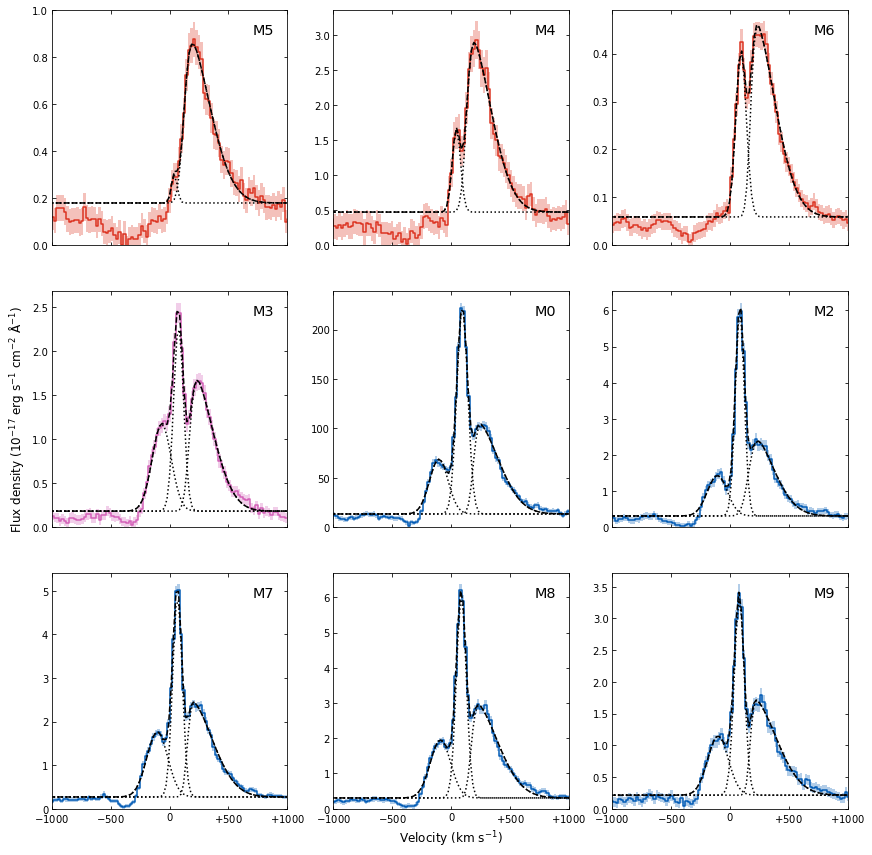

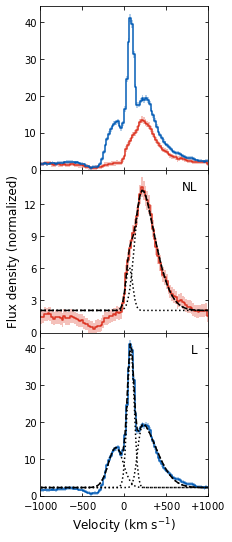

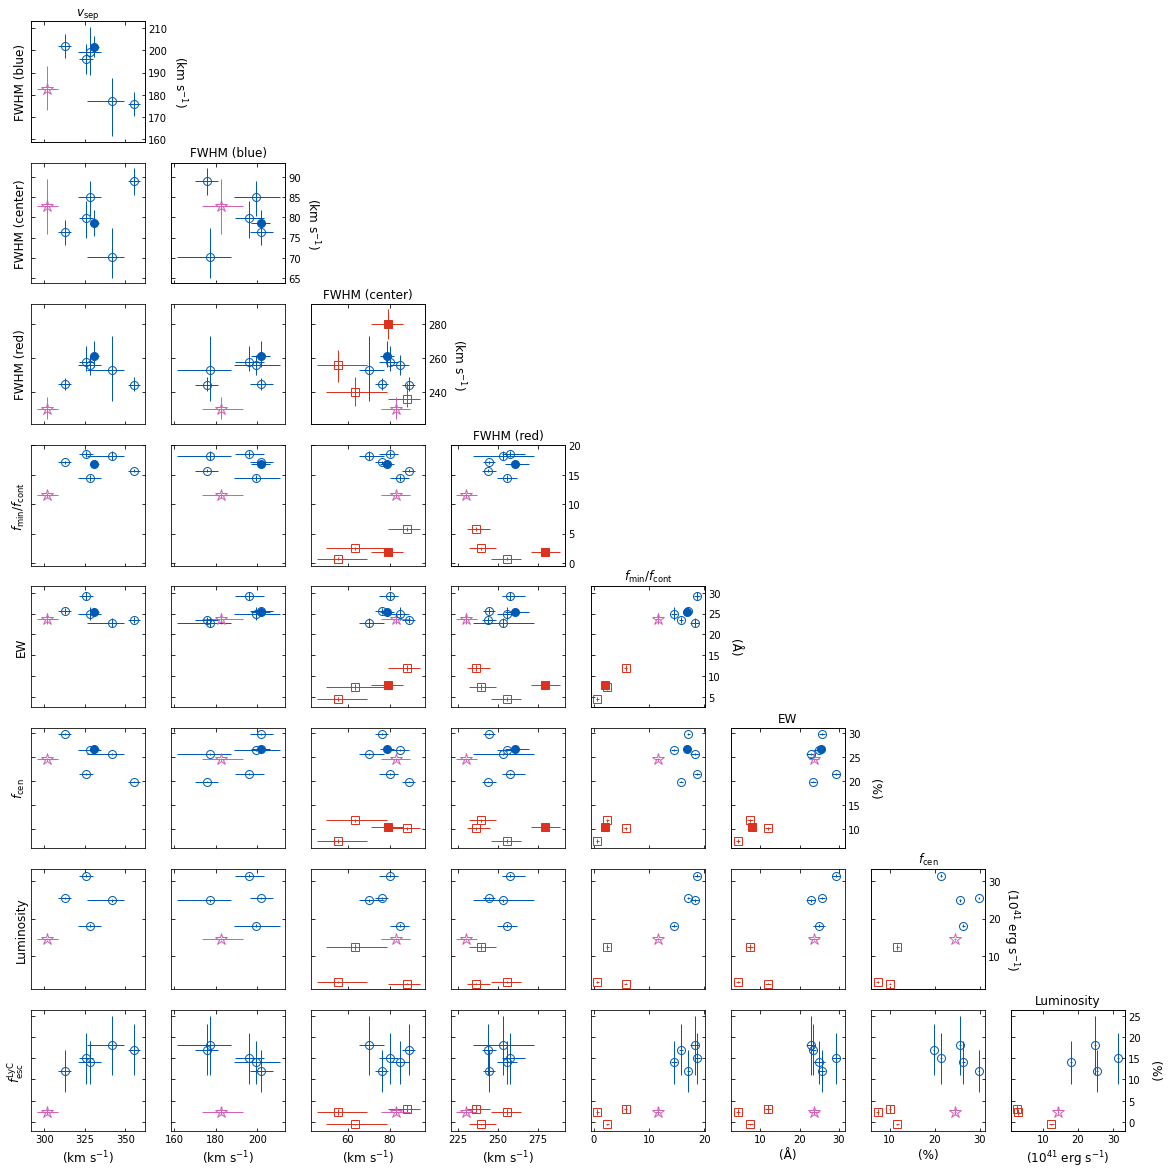

In [45]:
plot()

In [19]:
def extract_data(file):

    '''
    Extract spectrum from the .txt file

    Parameters:
        file : str
            Name of the file

    Returns:
        w : numpy.ndarray
            Observed wavelength bins
        f : numpy.ndarray
            Observed flux densities
        n : numpy.ndarray
            Observed Gaussian standard deviation of observed flux densities
    '''

    # Retrieve the data columns
    w, f, n = np.loadtxt(file, delimiter='\t', comments=('#', 'w'), usecols=(0,1,2), unpack=True)
    
    # If the file is not the stacked leaker spectrum. This step is necessary because 
    if 'leaker' not in file:

        # Remove bins of extreme outliers
        w = w[f < 1e-20]
        n = n[f < 1e-20]
        f = f[f < 1e-20]

        # Convert from units of erg/s/cm^2/Hz to erg/s/cm^2/Å
        f = f * 2.998e18 / np.square(w)
        n = n * 2.998e18 / np.square(w)

    return w, f, n    

@njit
def rest_frame(w, f, n, z):

    '''
    Place the data in the rest frame

    Parameters:
        w : numpy.ndarray
            Observed wavelength bins
        f : numpy.ndarray
            Observed flux densities
        n : numpy.ndarray
            Gaussian standard deviation of observed flux densities
        z : numpy.float64
            Redshift of the spectrum

    Returns:
        w : numpy.ndarray
            Rest wavelength bins
        f : numpy.ndarray
            Rest flux densities
        n : numpy.ndarray
            Gaussian standard deviation of rest flux densities
    '''

    w = w / (1 + z)
    f = f * (1 + z)
    n = n * (1 + z)

    return w, f, n

def compute_continuum(w, f):

    '''
    Compute the local continuum

    Parameters:
        w : numpy.ndarray
            Rest wavelength
        f : numpy.ndarray
            Rest flux density

    Returns:
        c : numpy.float64
            Local continuum flux density
    '''

    # Compute the local continuum as the
    # median flux density between 1221-1225 Å
    f = f[(w >= 1221) & (w <= 1225)]
    c = np.median(f)    

    return c

@njit
def compute_ew(w, f, c, results):

    '''
    Compute the EW of the Lyα profile

    Parameters:
        w : numpy.ndarray
            Rest wavelength
        f : numpy.ndarray
            Rest flux density
        c : numpy.float64
            Local continuum flux density
        results : numpy.ndarray
            Array containing measurements

    Returns:
        ew : numpy.float64
            Equivalent width
    '''

    # Compute the EW of the Lyα profile
    # between 1212-1221 Å
    f = f[(w >= 1212) & (w <= 1221)]
    w = w[(w >= 1212) & (w <= 1221)]
    ew = -1 * np.trapz(1 - f / c, w)

    results = np.append(results, ew)

    return results

@njit
def compute_fcen(v, f, results):

    '''
    '''

    # Compute the central escape fraction as a percent
    f_cen = np.trapz(f[(v >= -100) & (v <= 100)], v[(v >= -100) & (v <= 100)]) / np.trapz(f[(v >= -1000) & (v <= 1000)], v[(v >= -1000) & (v <= 1000)]) * 100
    results = np.append(results, f_cen)

    return results

def compute_l(w, f_mc, c, z, l_distance, l_results):

    f_mc = f_mc[(w >= 1212 * (1 + z)) & ((w <= 1221 * (1 + z)))]
    w = w[(w >= 1212 * (1 + z)) & ((w <= 1221 * (1 + z)))]

    flux = np.trapz(f_mc - c, w)

    l = 4 * np.pi * flux * l_distance**2
    l_results = np.append(l_results, l)

    return l_results


def compute_ratio(v, f_mc, c, c_peak_range, ratio_results):

    '''
    '''

    ratio = np.amax(f_mc[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]) / c
    ratio_results = np.append(ratio_results, ratio)

    return ratio_results

def fit_peaks(v, f_mc, c, c_peak_range, model, i):

    '''
    '''

    # If there is no blue peak
    if i in [0,3,4]:
        
        # Assign the initial guess and parameter bounds; this must be done inside the Monte Carlo loop to get the best initial
        # estimates so they can be built from the random sample
        p0 = (np.amax(f_mc[(v >= 150) & (v <= 1000)]),200,20,1,np.amax(f_mc[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]),80,40,c)
        bounds = ([0,0,0,0,0,0,0,0],[np.amax(f_mc),1000,np.inf,np.inf,np.amax(f_mc),200,85,np.mean(f_mc)])
    
    elif i in [2]:

        # Assign the initial guess and parameter bounds; this must be done inside the Monte Carlo loop to get the best initial
        # estimates so they can be built from the random sample
        p0 = (np.amax(f_mc[(v >= 150) & (v <= 1000)]),200,20,1,np.amax(f_mc[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]) - c,50,20,c)
        bounds = ([0,0,0,0,0,0,0,0],[np.amax(f_mc),500,np.inf,np.inf,np.amax(f_mc[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]) - c,100,40,np.amax(f_mc)])

    # Otherwise
    else:

        # Assign the initial guess and parameter bounds; this must be done inside the Monte Carlo loop to get the best initial
        # estimates so they can be built from the random sample
        p0 = (np.amax(f_mc[(v >= -1000) & (v <= 0)]),-150,20,-1,np.amax(f_mc[(v >= 150) & (v <= 1000)]),200,20,1,np.amax(f_mc[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]),80,40,c)
        bounds = ([0,-1000,0,-np.inf,0,0,0,0,0,0,0,0],[np.amax(f_mc[(v >= -1000) & (v <= 0)]),0,np.inf,0,np.amax(f_mc),1000,np.inf,np.inf,np.amax(f_mc),200,85,np.mean(f_mc)])

    p, cov = curve_fit(model, v, f_mc, p0=p0, bounds=bounds, maxfev=2000)

    return p, cov

def mc(w, v, f, n, z, c_peak_range, i):

    '''
    Parameters:
        w : numpy.ndarray
        f : numpy.ndarray
        n : numpy.ndarray
    '''

    def two_peaks(x, amp_r, cen_r, width_r, skew_r, amp_c, cen_c, width_c, cntm):

        return amp_r * np.exp(-((x - cen_r) / width_r)**2 / 2) * (1 + erf(skew_r * ((x - cen_r) / width_r) / np.sqrt(2))) \
            + amp_c * np.exp(-((x - cen_c) / width_c)**2 / 2) \
            + cntm

    def three_peaks(x, amp_b, cen_b, width_b, skew_b, amp_r, cen_r, width_r, skew_r, amp_c, cen_c, width_c, cntm):

        return amp_b * np.exp(-((x - cen_b) / width_b)**2 / 2) * (1 + erf(skew_b * ((x - cen_b) / width_b) / np.sqrt(2)))  \
            + amp_r * np.exp(-((x - cen_r) / width_r)**2 / 2) * (1 + erf(skew_r * ((x - cen_r) / width_r) / np.sqrt(2))) \
            + amp_c * np.exp(-((x - cen_c) / width_c)**2 / 2) \
            + cntm

    cosmology=FlatLambdaCDM(70,0.3)
    l_distance = cosmology.luminosity_distance(z).value * 3.086e24

    # If there is no blue peak
    if i in [0,2,3,4]:
        model = two_peaks
        fit_results = np.empty((1,8), dtype=np.float64)
    
    # Otherwise
    else:
        model = three_peaks
        fit_results = np.empty((1,12), dtype=np.float64)

    if i > 1:
        f = f * 1e17
        n = n * 1e17

    mag = np.array([1.0, 1.0, 50.7, 14.6, 147.0, 36.1, 10.4, 31.6, 34.6, 29.4, 30.9], dtype=np.float64)

    e_results = np.array([], dtype=np.float64)
    fcen_results = np.array([], dtype=np.float64)
    l_results = np.array([], dtype=np.float64)
    ratio_results = np.array([], dtype=np.float64)

    for s in range(1000):

        f_mc = np.random.normal(f, n)

        c = compute_continuum(w, f_mc)

        e_results = compute_ew(w, f_mc, c, e_results)

        fcen_results = compute_fcen(v, f_mc, fcen_results)

        l_results = compute_l(w * (1 + z), f_mc * 1e-17 / (1 + z) / mag[i], c * 1e-17 / (1 + z) / mag[i], z, l_distance, l_results)    

        #ratio_results = compute_ratio(v, f_mc, c, c_peak_range, ratio_results)

        try:

            p, _ = fit_peaks(v[(v >= -1000) & (v <= 1000) & (f_mc >= c)], f_mc[(v >= -1000) & (v <= 1000) & (f_mc >= c)], c, c_peak_range, model, i)
            
            ratio_results = np.append(ratio_results, p[-4] / p[-1])
            
            fit_results = np.append(fit_results, np.array([p]), axis=0)

            '''
            if i==0:

                fig, ax = plt.subplots()  

                ax.plot(v, f_mc, ds='steps-mid', color='black')
                ax.plot(v, model(v, *p), ls='dashed', color='red')
                ax.set_xlim(-1000,1000)
                plt.show()
            '''

        except RuntimeError:
            pass

    # Remove the first empty row that was created
    # when the array was initialized
    fit_results = fit_results[1:]

    for i, parameter in enumerate(fit_results.T):

        #print(f'$np.median(parameter)_-{abs(np.median(parameter) - np.percentile(parameter, 16))}r}^r{+{abs(np.percentile(parameter, 84) - np.median(parameter))}r}$')
        print('$' + str(np.median(parameter)) + \
            '_{-' + str(sf_round(abs(np.median(parameter) - np.percentile(parameter, 16)),1)) + '}' + \
            '^{+' + str(sf_round(abs(np.percentile(parameter, 84) - np.median(parameter)),1)) + '}' + \
            '$')

    return fit_results, e_results, fcen_results, ratio_results, l_results

def compute_fwhm_and_peak(amp, cen, width, skew, R, R_error):

    '''
    Returns:
        fwhm : numpy.float64
        loc : numpy.float64
    '''
    def lin_interp(x, y, i, half):
        return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

    def model(x, amp, cen, width, skew):

        return amp * np.exp(-((x - cen) / width)**2 / 2) * (1 + erf(skew * ((x - cen) / width) / np.sqrt(2)))

    v = np.arange(-1000,1000,0.1)

    peak = model(v, amp, cen, width, skew)    

    loc = v[np.argmax(peak)]

    half = np.amax(peak) / 2.0
    signs = np.sign(np.add(peak, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]

    fwhm = abs(lin_interp(v, peak, zero_crossings_i[0], half) - lin_interp(v, peak, zero_crossings_i[1], half))

    res = np.random.normal(R, R_error)

    fwhm = np.sqrt((fwhm)**2 - (res)**2)

    return fwhm, loc

def label(fig, ax, fig_stack, ax_stack):

    slits = np.array(['M5','M4','M6','M3','M0','M2','M7','M8','M9'], dtype=str)    

    for i, row in enumerate(ax):

        row[-1].yaxis.set_label_position('right')
        row[-1].set_ylabel(slits[i], rotation=-90, labelpad=10)

    ax_stack[0,6].yaxis.set_label_position('right')
    ax_stack[0,6].set_ylabel('NL', rotation=-90, labelpad=10)

    ax_stack[1,6].yaxis.set_label_position('right')
    ax_stack[1,6].set_ylabel('L', rotation=-90, labelpad=10)

    ax[3,0].set_title(r'$v_{\rm{sep}}$')
    ax[3,1].set_title('FWHM (blue)')
    ax[0,2].set_title('FWHM (center)')
    ax[0,3].set_title('FWHM (red)')
    ax[0,4].set_title(r'$f_{\rm{min}}/f_{\rm{cont}}$')
    ax[0,5].set_title('EW')
    ax[0,6].set_title(r'$f_{\rm{cen}}$')
    ax[0,7].set_title('Luminosity')
    
    ax_stack[1,0].set_title(r'$v_{\rm{sep}}$')
    ax_stack[1,1].set_title('FWHM (blue)')
    ax_stack[0,2].set_title('FWHM (center)')
    ax_stack[0,3].set_title('FWHM (red)')
    ax_stack[0,4].set_title(r'$f_{\rm{min}}/f_{\rm{cont}}$')
    ax_stack[0,5].set_title('EW')
    ax_stack[0,6].set_title(r'$f_{\rm{cen}}$')

    xlabels = np.array(['(km s$^{-1}$)','(km s$^{-1}$)','(km s$^{-1}$)',
        '(km s$^{-1}$)','',r'($\rm{\AA}$)','(%)','(10$^{42}$ erg s$^{-1}$)'], dtype=str)

    for i, column in enumerate(ax.T):

        ax[8,i].set_xlabel(xlabels[i])

    for i, column in enumerate(ax_stack.T):

        ax_stack[1,i].set_xlabel(xlabels[i])

    fig.supxlabel(r'$x-\mu$')
    fig.supylabel('Count')

    fig_stack.supxlabel(r'$x-\mu$')
    fig_stack.supylabel('Count')

def set_ticks(ax, ax_stack):

    for i, row in enumerate(ax):

        for j, column in enumerate(row):

            if j == 7:
                ax[i,j].tick_params(bottom=True, left=True, right=False)

            else:
                ax[i,j].tick_params(bottom=True, left=True, right=True)

    ax[0,2].tick_params(labelleft=True)
    ax[1,2].tick_params(labelleft=True)
    ax[2,2].tick_params(labelleft=True)

    for i, row in enumerate(ax_stack):

        for j, column in enumerate(row):

            if j == 6:
                ax_stack[i,j].tick_params(bottom=True, left=True, right=False)

            else:
                ax_stack[i,j].tick_params(bottom=True, left=True, right=True)

    ax_stack[0,2].tick_params(labelleft=True)

def disable_plots(ax, ax_stack):

    ax_stack[0,0].axis('off')    
    ax_stack[0,1].axis('off')    

    for i in [0,1,2]:

        ax[i,0].axis('off')
        ax[i,1].axis('off')

def make_corner_plot():

    '''
    '''

    fig, ax = plt.subplots(8,8, figsize=(16,16), sharex='col', sharey='row', constrained_layout=True)
    fig.tight_layout()

    for i, row in enumerate(ax):

        for j, subplot in enumerate(row):

            subplot.set_aspect(1 / subplot.get_data_ratio(), adjustable='box')

            if j > i:
                ax[i,j].axis('off')
    
    #ax[0,0].set_aspect(1 / subplot.get_data_ratio(), adjustable='datalim')
    #ax_dummy = fig.add_axes(ax[0,0].get_position())

    #ax_dummy = ax[0,0].twinx()    
    #ax_dummy.set_aspect('equal')

    #row_titles = np.array(['FWHM(center)','FWHM (red)',r'$f_{\rm{min}}/f_{\rm{cont}}$','EW',r'$f_{\rm{cen}}$','Luminosity',r'$f_{\rm{esc}}^{\rm{LyC}}$'], dtype=str)

    row_titles = np.array(['FWHM (blue)', 'FWHM (center)', 'FWHM (red)', 
        r'$f_{\rm{min}}/f_{\rm{cont}}$', 'EW', r'$f_{\rm{cen}}$',
        'Luminosity', r'$f_{\rm{esc}}^{\rm{LyC}}$'], dtype=str)
    column_titles = np.array([r'$v_{\rm{sep}}$', 'FWHM (blue)', 'FWHM (center)',
        'FWHM (red)', r'$f_{\rm{min}}/f_{\rm{cont}}$', 'EW', 
        r'$f_{\rm{cen}}$', 'Luminosity'], dtype=str)
    column_labels = np.array(['(km s$^{-1}$)', '(km s$^{-1}$)', '(km s$^{-1}$)',
        '(km s$^{-1}$)', '', r'($\rm{\AA}$)',
        '(%)', '(10$^{42}$ erg s$^{-1}$)'], dtype=str)
    row_labels = np.array(['(km s$^{-1}$)', '(km s$^{-1}$)', '(km s$^{-1}$)',
        '', r'($\rm{\AA}$)', '(%)', '(10$^{42}$ erg s$^{-1}$)', '(%)'], dtype=str)

    for i, row in enumerate(ax):

        ax[i,0].set_ylabel(row_titles[i], fontsize='large')
        ax[i,i].set_title(column_titles[i])

        ax[7,i].set_xlabel(column_labels[i], fontsize='large')

        if i > 0:
            ax[i,i].yaxis.set_label_position('right')
            ax[i,i].set_ylabel(row_labels[i], fontsize='large')

    for i, row in enumerate(ax):

        for j, subplot in enumerate(row):

            # Subplots on the interior
            if ((i != j) & (i != 7) & (j != 0)):
                subplot.tick_params(left=True, right=True, bottom=True, top=True,
                    labelleft=False, labelright=False, labelbottom=False, labeltop=False, direction='in')

            # Subplots on the main diagonal but not the corners
            elif ((i == j) & (i != 7) & (j != 0)):
                subplot.tick_params(left=True, right=True, bottom=True, top=True,
                    labelleft=False, labelright=True, labelbottom=False, labeltop=False, direction='in')
            
            # Subplots on the left column but not the corners
            elif ((j == 0) & (i != 0) & (i != 7)):
                subplot.tick_params(left=True, right=True, bottom=True, top=True,
                    labelleft=False, labelright=False, labelbottom=False, labeltop=False, direction='in')

            # Subplots on the bottom row but not the corners
            elif ((i == 7) & (j != 0) & (j != 7)):
                subplot.tick_params(left=True, right=True, bottom=True, top=True,
                    labelleft=False, labelright=False, labelbottom=True, labeltop=False, direction='in')

    ax[0,0].tick_params(left=True, right=True, bottom=True, top=True,
        labelleft=False, labelright=False, labelbottom=False, labeltop=False, direction='in')
    ax[7,0].tick_params(left=True, right=True, bottom=True, top=True,
        labelleft=False, labelright=False, labelbottom=True, labeltop=False, direction='in')
    ax[7,7].tick_params(left=True, right=True, bottom=True, top=True,
        labelleft=False, labelright=True, labelbottom=True, labeltop=False, direction='in')

    return fig, ax

def gaussian(x, amp, cen, width):
    return amp * np.exp(-((x - cen) / width)**2 / 2)

def skewed_gaussian(x, amp, cen, width, skew):
    return amp * np.exp(-((x - cen) / width)**2 / 2) * (1 + erf(skew * ((x - cen) / width) / np.sqrt(2)))

def measure():

    # Establish directories
    home = os.getcwd()
    data = home + '/data'
    figs = home + '/figs'

    #files = glob.glob(data + '/spectra/mage/*MWdr.txt')

    files = np.array(['rest_sba-nonleaker-no_m3_MWdr.txt','rest_sba-leaker-no_m0_MWdr.txt',
                      'psz-arcslit-h3-comb1_MWdr.txt', 'psz-arcslit-h1-comb1_MWdr.txt',
                      'sunburst_M-6-comb1_MWdr.txt', 'psz-arcslit-h4-comb1_MWdr.txt',
                      'planckarc_pos1-comb1_MWdr.txt', 'psz-arcslit-h6-comb1_MWdr.txt',
                      'psz-arcslit-h9-comb1_MWdr.txt', 'psz-arcslit-f-comb1_MWdr.txt',
                      'psz-arcslit-h2-comb1_MWdr.txt'], dtype=object)
    names = np.array(['NL', 'L', 'M5', 'M4', 'M6', 'M3', 'M0', 'M2', 'M7', 'M8', 'M9'], dtype=str)

    f_esc = [2.3, -0.6, 3, 2.3, 17, 18, 12, 15, 14]
    ne_esc = [0.8, 0.2, 1, 0.8, 6, 7, 5, 6, 5]

    # For each file
    for i, file in enumerate(files):

        # Join its folder path to the file name
        file = ''.join([data, '/spectra/mage/', file])
        files[i] = file

    z = np.array([0, 0, 2.37086, 2.37073, 2.37021, 2.37025, 2.37014, 2.37017, 2.37044, 
                  2.37024, 2.37030], dtype=np.float64)
    c_peak_range = np.array([[60,140],[20,130],[0,100],[0,85],[10,130],[35,120],[10,130],
                             [45,125],[15,100],[25,125],[15,125]], dtype=np.float64)

    fig_mc, ax_mc = plt.subplots(9,8, figsize=(16,18), sharey='row', constrained_layout=True)
    fig_mc_stack, ax_mc_stack = plt.subplots(2,7, figsize=(21,6), sharey='row', constrained_layout=True)

    fig_lya, ax_lya = plt.subplots(3,3, figsize=(12,12), sharex=True, constrained_layout=True)
    ax_lya_array = np.array(ax_lya).reshape(-1)

    fig_lya_stack, ax_lya_stack = plt.subplots(3,1, figsize=(3,9), sharex=True)#, constrained_layout=True)
    #fig_lya_stack.subplots_adjust(hspace=0, wspace=0)

    fig_c, ax_c = make_corner_plot()

    total_result = np.array([np.empty((9,1000))])

    mag = np.array([1.0, 1.0, 50.7, 14.6, 147.0, 36.1, 10.4, 31.6, 34.6, 29.4, 30.9], dtype=np.float64)

    R = np.array([
        299792.458 / 5400,
        299792.458 / 5300,
        299792.458 / 5500,
        299792.458 / 5400,
        299792.458 / 5300,
        299792.458 / 5500,
        299792.458 / 4700,
        299792.458 / 5300,
        299792.458 / 5200,
        299792.458 / 5200,
        299792.458 / 5500
    ])

    R_error = np.array([
        299792.458 / 5400**2 * 200,
        299792.458 / 5300**2 * 200,
        299792.458 / 5500**2 * 400,
        299792.458 / 5400**2 * 300,
        299792.458 / 5300**2 * 300,
        299792.458 / 5500**2 * 400,
        299792.458 / 4700**2 * 200,
        299792.458 / 5300**2 * 300,
        299792.458 / 5200**2 * 200,
        299792.458 / 5200**2 * 300,
        299792.458 / 5500**2 * 400
    ])

    # For each spectrum
    for i, file in enumerate(files):

        print(names[i])

        # Extract the data from the .txt file
        w, f, n = extract_data(file)

        # Place the data in the rest frame
        w, f, n = rest_frame(w, f, n, z[i])

        f = f[(w >= 1195) & (w <= 1235)]
        n = n[(w >= 1195) & (w <= 1235)]
        w = w[(w >= 1195) & (w <= 1235)]

        v = 299792.458 * (w / 1215.67 - 1)

        #cosmology = FlatLambdaCDM(70, 0.3)
        #l_distance = cosmology.luminosity_distance(z[i]).value * 3.086e24

        fit_results, e_results, fcen_results, ratio_results, l_results = mc(w, v, f, n, z[i], c_peak_range[i], i)    

        median_fit = [np.median(e) for e in fit_results.T]

        # Take the transpose of the results so that the rows
        # are by parameter, not sample number
        #fit_results = fit_results.T

        if i in [0,2,3,4]:
            stdv_c_results = fit_results.T[6]
            fwhm_c_results = 2 * np.sqrt(2 * np.log(2)) * stdv_c_results

            fwhm_b_results = np.array([], dtype=np.float64)
            fwhm_c_results = np.array([], dtype=np.float64)
            fwhm_r_results = np.array([], dtype=np.float64)
            vsep_results = np.array([], dtype=np.float64)

            for j, sample in enumerate(fit_results):

                fwhm_r, _ = compute_fwhm_and_peak(sample[0], sample[1], sample[2], sample[3], R[i], R_error[i])
                fwhm_r_results = np.append(fwhm_r_results, fwhm_r)

                fwhm_c, _ = compute_fwhm_and_peak(sample[4], sample[5], sample[6], 0, R[i], R_error[i])
                fwhm_c_results = np.append(fwhm_c_results, fwhm_c)

                if np.isnan(fwhm_c):
                    print(i, fwhm_c)

        else:
            stdv_c_results = fit_results.T[10]
            fwhm_c_results = 2 * np.sqrt(2 * np.log(2)) * stdv_c_results

            fwhm_b_results = np.array([], dtype=np.float64)
            fwhm_c_results = np.array([], dtype=np.float64)
            fwhm_r_results = np.array([], dtype=np.float64)
            vsep_results = np.array([], dtype=np.float64)

            for j, sample in enumerate(fit_results):

                fwhm_b, loc_b = compute_fwhm_and_peak(sample[0], sample[1], sample[2], sample[3], R[i], R_error[i])
                fwhm_b_results = np.append(fwhm_b_results, fwhm_b)

                fwhm_c, _ = compute_fwhm_and_peak(sample[8], sample[9], sample[10], 0, R[i], R_error[i])
                fwhm_c_results = np.append(fwhm_c_results, fwhm_c)

                if np.isnan(fwhm_c):
                    print(i, fwhm_c)

                fwhm_r, loc_r = compute_fwhm_and_peak(sample[4], sample[5], sample[6], sample[7], R[i], R_error[i])
                fwhm_r_results = np.append(fwhm_r_results, fwhm_r)

                vsep = abs(loc_r - loc_b)
                vsep_results = np.append(vsep_results, vsep)

        fwhm_c_results = fwhm_c_results[~np.isnan(fwhm_c_results)]

        # If the spectrum is one of the stacked spectra
        if i < 2:

            if i == 0:
                color='#DC3220'
                markersize = 8
            else:
                color='#005AB5'
                markersize = 8

            ax_mc_stack[i,0].hist(vsep_results - np.median(vsep_results), bins=30, color=color)
            ax_mc_stack[i,1].hist(fwhm_b_results - np.median(fwhm_b_results), bins=30, color=color)
            ax_mc_stack[i,2].hist(fwhm_c_results - np.median(fwhm_c_results), bins=30, color=color)
            ax_mc_stack[i,3].hist(fwhm_r_results - np.median(fwhm_r_results), bins=30, color=color)
            ax_mc_stack[i,4].hist(ratio_results - np.median(ratio_results), bins=30, color=color)
            ax_mc_stack[i,5].hist(e_results - np.median(e_results), bins=30, color=color)
            ax_mc_stack[i,6].hist(fcen_results - np.median(fcen_results), bins=30, color=color)

            results = [vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results]
            r = np.array([None,None,None,None,1,1,1])
            tau = np.array([None,None,None,None,1,1,1])
            rho = np.array([None,None,None,None,1,1,1])

            # For each subplot in a row
            for j, subplot in enumerate(ax_mc_stack[i]):

                try:

                    median = np.median(results[j][~np.isnan(results[j])])
                    lower = sigfig.round(str(median - np.percentile(results[j][~np.isnan(results[j])], 16)), 2)
                    upper = sigfig.round(str(np.percentile(results[j][~np.isnan(results[j])], 84) - median), 2)

                    # If both percentiles are greater than 10, they will not have
                    # any significant figures past the decimal place
                    if abs(float(lower)) >= 10 and abs(float(upper)) >= 10:
                        # Find the smallest value between the two percentiles
                        string = str(np.amin([int(lower), int(upper)]))

                        # Count the number of zeros in the string
                        zeros = string.count('0')

                        # If the length of the string differs by only one from
                        # the number of zeros, this indicates one of the 2 
                        # significant figures is a zero, so to prevent the median
                        # from being rounded prematurely (to the significant figure
                        # before the zero), subtract the number of zeros by one
                        if len(string) == zeros + 1:
                            zeros = zeros - 1

                        zeros = -1 * zeros

                        median = str(int(round(median, zeros)))

                    elif (abs(float(lower)) >= 10 and abs(float(upper)) < 10) or (abs(float(lower)) < 10 and abs(float(upper)) >= 10):
                        print('check')

                        if abs(float(lower)) >= 10:
                            median = str(round(median, len(upper.split('.')[1])))
                        if abs(float(upper)) >= 10:
                            median = str(round(median, len(lower.split('.')[1])))
                        # Round the median to the smallest digit place between the upper and lower percentiles   
                        #median = str(round(median, np.amax([len(lower.split('.')[1]), len(upper.split('.')[1])])))

                    # Otherwise, since the percentiles are rounded to 2 significant
                    # figures, they will have at least one significant digit past
                    # the decimal place
                    else:
                        # Round the median to the smallest digit place between the upper and lower percentiles   
                        median = str(round(median, np.amax([len(lower.split('.')[1]), len(upper.split('.')[1])])))

                    at = AnchoredText('$' + median + '_{-' + lower + '}^{+' + upper + '}$',
                        loc='upper right', frameon=False)
                    subplot.add_artist(at)

                # Except if there are no results for the parameter
                # (because it was inapplicable to the profile)
                except IndexError:
                    pass

            ax_lya_stack[0].fill_between(v[(v >= -1100) & (v <= 1100)], (f - 3 * n)[(v >= -1100) & (v <= 1100)], (f + 3 * n)[(v >= -1100) & (v <= 1100)], step='mid', facecolor=color, alpha=0.3)
            ax_lya_stack[0].plot(v[(v >= -1100) & (v <= 1100)], f[(v >= -1100) & (v <= 1100)], ds='steps-mid', c=color)

            for j, result_row in enumerate([fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results]):
                
                # If this is the stacked nonleaker spectrum
                if i == 0:
                    if j == 0:
                        pass
                    else:
                        for k, result_col in enumerate([fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results]):
                            
                            if k + 2 > j:
                                pass
                            else:
                                ax_c[j,k+2].errorbar(np.median(result_col), np.median(result_row), 
                                    xerr=[[np.median(result_col) - np.percentile(result_col, 16)], [np.percentile(result_col, 84) - np.median(result_col)]], 
                                    yerr=[[np.median(result_row) - np.percentile(result_row, 16)], [np.percentile(result_row, 84) - np.median(result_row)]],
                                    lw=1, marker='s', markersize=markersize, mec=color, mfc=color, ecolor=color)
                else:
                    for k, col in enumerate([vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results]):

                        if k > j:
                            pass
                        else:
                            ax_c[j,k].errorbar(np.median(col), np.median(result_row),
                                xerr=[[np.median(col) - np.percentile(col, 16)], [np.percentile(col, 84) - np.median(col)]], 
                                yerr=[[np.median(result_row) - np.percentile(result_row, 16)], [np.percentile(result_row, 84) - np.median(result_row)]],
                                lw=1, marker='o', markersize=markersize, mec=color, mfc=color, ecolor=color)

            if i == 0:

                ax_lya_stack[1].fill_between(v[(v >= -1100) & (v <= 1100)], (f - 3 * n)[(v >= -1100) & (v <= 1100)], (f + 3 * n)[(v >= -1100) & (v <= 1100)], step='mid', facecolor=color, alpha=0.3)
                ax_lya_stack[1].plot(v[(v >= -1100) & (v <= 1100)], f[(v >= -1100) & (v <= 1100)], ds='steps-mid', c=color)
                ax_lya_stack[1].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[4], median_fit[5], median_fit[6]) + median_fit[7])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_stack[1].plot(v[(v >= -1100) & (v <= 1100)],
                    (skewed_gaussian(v, median_fit[0], median_fit[1], median_fit[2], median_fit[3]) + median_fit[7])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_stack[1].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[4], median_fit[5], median_fit[6]) + skewed_gaussian(v, median_fit[0], median_fit[1], median_fit[2], median_fit[3]) + median_fit[7])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dashed')

            else:

                ax_lya_stack[2].fill_between(v[(v >= -1100) & (v <= 1100)], (f - 3 * n)[(v >= -1100) & (v <= 1100)], (f + 3 * n)[(v >= -1100) & (v <= 1100)], step='mid', facecolor=color, alpha=0.3)
                ax_lya_stack[2].plot(v[(v >= -1100) & (v <= 1100)], f[(v >= -1100) & (v <= 1100)], ds='steps-mid', c=color)
                ax_lya_stack[2].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[8], median_fit[9], median_fit[10]) + median_fit[11])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_stack[2].plot(v[(v >= -1100) & (v <= 1100)],
                    (skewed_gaussian(v, median_fit[0], median_fit[1], median_fit[2], median_fit[3]) + median_fit[11])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_stack[2].plot(v[(v >= -1100) & (v <= 1100)],
                    (skewed_gaussian(v, median_fit[4], median_fit[5], median_fit[6], median_fit[7]) + median_fit[11])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_stack[2].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[8], median_fit[9], median_fit[10]) + skewed_gaussian(v, median_fit[4], median_fit[5], median_fit[6], median_fit[7]) + skewed_gaussian(v, median_fit[0], median_fit[1], median_fit[2], median_fit[3]) + median_fit[11])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dashed')

        # If the spectrum is not one of the stacked spectra
        elif i > 1:

            if i in [2,3,4]:
                color='#DC3220'
                marker = 's'
                markersize = 8

            elif i == 5:
                color='#D35FB7'
                marker = '*'
                markersize = 10

            else:
                color='#005AB5'
                marker = 'o'
                markersize = 8

            ax_mc[i-2,0].hist(vsep_results - np.median(vsep_results), bins=30, color=color)
            ax_mc[i-2,1].hist(fwhm_b_results - np.median(fwhm_b_results), bins=30, color=color)
            ax_mc[i-2,2].hist(fwhm_c_results - np.median(fwhm_c_results), bins=30, color=color)
            ax_mc[i-2,3].hist(fwhm_r_results - np.median(fwhm_r_results), bins=30, color=color)
            ax_mc[i-2,4].hist(ratio_results - np.median(ratio_results), bins=30, color=color)
            ax_mc[i-2,5].hist(e_results - np.median(e_results), bins=30, color=color)
            ax_mc[i-2,6].hist(fcen_results - np.median(fcen_results), bins=30, color=color)
            ax_mc[i-2,7].hist((l_results - np.median(l_results)) * 1e-42, bins=30, color=color)
            
            results = [vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42]
            r = np.array([None,None,None,None,1,1,1,1])
            tau = np.array([None,None,None,None,1,1,1,1])
            rho = np.array([None,None,None,None,1,1,1,1])

            # For each subplot in a row
            for j, subplot in enumerate(ax_mc[i-2]):

                try:

                    #median = np.median(results[j])
                    #lower = median - np.percentile(results[j], 16)
                    #upper = np.percentile(results[j], 84) - median

                    median = np.median(results[j][~np.isnan(results[j])])
                    lower = sigfig.round(str(median - np.percentile(results[j][~np.isnan(results[j])], 16)), 2)
                    upper = sigfig.round(str(np.percentile(results[j][~np.isnan(results[j])], 84) - median), 2)

                    #print(median, lower, upper)

                    # If both percentiles are greater than 10, they will not have
                    # any significant figures past the decimal place
                    if abs(float(lower)) >= 10 and abs(float(upper)) >= 10:
                        # Find the smallest value between the two percentiles
                        string = str(np.amin([int(lower), int(upper)]))

                        # Count the number of zeros in the string
                        zeros = string.count('0')

                        # If the length of the string differs by only one from
                        # the number of zeros, this indicates one of the 2 
                        # significant figures is a zero, so to prevent the median
                        # from being rounded prematurely (to the significant figure
                        # before the zero), subtract the number of zeros by one
                        if len(string) == zeros + 1:
                            zeros = zeros - 1

                        zeros = -1 * zeros

                        median = str(int(round(median, zeros)))
                    
                    elif (abs(float(lower)) >= 10 and abs(float(upper)) < 10) or (abs(float(lower)) < 10 and abs(float(upper)) >= 10):
                        print('check')
                        
                        if abs(float(lower)) >= 10:
                            formatter = '{:.' + str(len(upper.split('.')[1])) + 'f}'
                            median = formatter.format(round(median, len(upper.split('.')[1])))
                        if abs(float(upper)) >= 10:
                            formatter = '{:.' + str(len(lower.split('.')[1])) + 'f}'
                            median = formatter.format(round(median, len(lower.split('.')[1])))
                        # Round the median to the smallest digit place between the upper and lower percentiles   
                        #median = str(round(median, np.amax([len(lower.split('.')[1]), len(upper.split('.')[1])])))

                    # Otherwise, since the percentiles are rounded to 2 significant
                    # figures, they will have at least one significant digit past
                    # the decimal place
                    else:
                        # Round the median to the smallest digit place between the upper and lower percentiles   
                        formatter = '{:.' + str(np.amax([len(lower.split('.')[1]), len(upper.split('.')[1])])) + 'f}'
                        median = formatter.format(round(median, np.amax([len(lower.split('.')[1]), len(upper.split('.')[1])])))

                    #at = AnchoredText('$' + str(round(median, r[j])) + '_{-' + str(round(lower, r[j])) + '}^{+' + str(round(upper, r[j])) + '}$',
                    #    loc='upper right', frameon=False)
                    at = AnchoredText('$' + median + '_{-' + lower + '}^{+' + upper + '}$',
                        loc='upper right', frameon=False)
                    subplot.add_artist(at)

                # Except if there are no results for the parameter
                # (because it was inapplicable to the profile)
                except IndexError:
                    pass

            ax_lya_array[i-2].fill_between(v[(v >= -1100) & (v <= 1100)], (f / mag[i] - 2 * n / mag[i])[(v >= -1100) & (v <= 1100)] * 1e17, (f / mag[i] + 2 * n / mag[i])[(v >= -1100) & (v <= 1100)] * 1e17, step='mid', facecolor=color, alpha=0.3)
            ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)], (f / mag[i])[(v >= -1100) & (v <= 1100)] * 1e17, ds='steps-mid', c=color)

            if i in [2,3,4]:

                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[4] / mag[i], median_fit[5], median_fit[6]) + median_fit[7] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (skewed_gaussian(v, median_fit[0] / mag[i], median_fit[1], median_fit[2], median_fit[3]) + median_fit[7] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[4] / mag[i], median_fit[5], median_fit[6]) + skewed_gaussian(v, median_fit[0] / mag[i], median_fit[1], median_fit[2], median_fit[3]) + median_fit[7] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dashed')

            else:

                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[8] / mag[i], median_fit[9], median_fit[10]) + median_fit[11] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (skewed_gaussian(v, median_fit[0] / mag[i], median_fit[1], median_fit[2], median_fit[3]) + median_fit[11] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (skewed_gaussian(v, median_fit[4] / mag[i], median_fit[5], median_fit[6], median_fit[7]) + median_fit[11] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[8] / mag[i], median_fit[9], median_fit[10]) + skewed_gaussian(v, median_fit[4] / mag[i], median_fit[5], median_fit[6], median_fit[7]) + skewed_gaussian(v, median_fit[0] / mag[i], median_fit[1], median_fit[2], median_fit[3]) + median_fit[11] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dashed')

            at = AnchoredText(names[i], loc='upper right', frameon=False, prop=dict(fontsize='large'))
            ax_lya_array[i-2].add_artist(at)

            ax_lya_array[i-2].set_xlim(-1000,1000)
            ax_lya_array[i-2].set_ylim(bottom=0)

            # For each parameter row
            for j, row in enumerate([fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42, f_esc[i-2]]):
                
                # If the spectrum does not have a triple peak
                if i in [2,3,4]:
                    
                    # For each parameter column
                    for k, col in enumerate([fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42]):
                        if k + 2 > j:
                            pass
                        else:
                            if j == 0:
                                pass
                            elif j == 7:
                                ax_c[j,k+2].errorbar(np.median(col), f_esc[i-2],
                                    xerr=[[np.median(col) - np.percentile(col, 16)], [np.percentile(col, 84) - np.median(col)]], 
                                    yerr=ne_esc[i-2],
                                    lw=1, marker=marker, markersize=markersize, mec=color, mfc='none', ecolor=color)
                            else:
                                ax_c[j,k+2].errorbar(np.median(col), np.median(row),
                                    xerr=[[np.median(col) - np.percentile(col, 16)], [np.percentile(col, 84) - np.median(col)]], 
                                    yerr=[[np.median(row) - np.percentile(row, 16)], [np.percentile(row, 84) - np.median(row)]],
                                    lw=1, marker=marker, markersize=markersize, mec=color, mfc='none', ecolor=color)
                else:
                    for k, col in enumerate([vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42]):
                        
                        # If the row / column combination is above the main diagonal
                        if k > j:
                            pass

                        else:
                            if (j == 7) and (i != 6):
                                ax_c[j,k].errorbar(np.median(col), f_esc[i-2],
                                    xerr=[[np.median(col) - np.percentile(col, 16)], [np.percentile(col, 84) - np.median(col)]], 
                                    yerr=ne_esc[i-2],
                                    lw=1, marker=marker, markersize=markersize, mec=color, mfc='none', ecolor=color)
                            elif (j == 7) and (k != 7) and (i == 6):
                                ax_c[j,k].errorbar(np.median(col), f_esc[i-2],
                                    xerr=[[np.median(col) - np.percentile(col, 16)], [np.percentile(col, 84) - np.median(col)]], 
                                    yerr=ne_esc[i-2],
                                    lw=1, marker=marker, markersize=markersize, mec=color, mfc='none', ecolor=color)
                            elif (j == 6 or k == 7) and (i == 6):
                                pass
                            else:
                                ax_c[j,k].errorbar(np.median(col), np.median(row),
                                    xerr=[[np.median(col) - np.percentile(col, 16)], [np.percentile(col, 84) - np.median(col)]], 
                                    yerr=[[np.median(row) - np.percentile(row, 16)], [np.percentile(row, 84) - np.median(row)]],
                                    lw=1, marker=marker, markersize=markersize, mec=color, mfc='none', ecolor=color)

        # If the spectrum is not a stacked one
        if i > 1:
            # Create pseudo-measurements of the LyC escape fraction assuming the calculated value and standard deviation
            # correspond to a Gaussian mean and standard deviation
            fesc_results = np.random.normal(f_esc[i-2], ne_esc[i-2], 1000)

        else:
            fesc_results = np.empty(1000)
            fesc_results[:] = np.nan

        slit_result = np.array([np.empty(1000)])

        for j, result in enumerate([vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42, fesc_results]):
            
            # Try to append any missing values as NaNs
            try:
                if len(result) < 1000:
                    a = np.empty(1000 - len(result))
                    a[:] = np.nan

                    result = np.append(result, a)

            # Unless the array has not been instantiated
            except TypeError:
                result = np.empty(1000)
                result[:] = np.nan
            
            if (i == 6) and (j == 7):
                result = np.empty(1000)
                result[:] = np.nan

            result = np.where(result != 0.0, result, np.nan)

            slit_result = np.append(slit_result, np.array([result]), axis=0)

        # Drop the first row since it is empty
        slit_result = slit_result[1:]

        total_result = np.append(total_result, np.array([slit_result]), axis=0)

    total_result = total_result[1:]

    r_locs = [[3,0,0,0,0,0,0,0],
        [2,4,0,0,0,0,0,0],
        [1,1,2,0,0,0,0,0],
        [3,3,2,7,0,0,0,0],
        [3,3,2,7,2,0,0,0],
        [3,3,2,7,2,2,1,1],
        [3,3,2,1,2,2,2,1],
        [2,'center left',2,4,2,2,2,2]]

    # For each row in the corner plot
    for i, row in enumerate(ax_c):

        # For each column in the corner plot
        for j, subplot in enumerate(row):

            r_results = np.array([], dtype=np.float64)
            tau_results = np.array([], dtype=np.float64)
            rho_results = np.array([], dtype=np.float64)

            # If the row / column pair is above the main diagonal
            if j > i:
                pass
            else:

                x_data = np.empty(1000)
                x_data[:] = np.nan
                x_data = np.array([x_data])
                y_data = np.empty(1000)
                y_data[:] = np.nan
                y_data = np.array([y_data])

                # For each spectrum
                for k, slit in enumerate(total_result):
                    
                    if all(np.isnan(slit[j])) or all(np.isnan(slit[i + 1])):
                        pass
                    else:
                        #if ~all(np.isnan(slit[j])) and ~all(np.isnan(slit[j + 1])):
                        x_data = np.append(x_data, np.array([slit[j]]), axis=0)
                        y_data = np.append(y_data, np.array([slit[i + 1]]), axis=0)
                        #pass
                    '''
                    else:
                        x_data = np.append(x_data, np.array([slit[j]]), axis=0)
                        y_data = np.append(x_data, np.array([slit[j + 1]]), axis=0)
                    '''

                x_data = x_data[1:]
                y_data = y_data[1:]

                #r_results = np.array([], dtype=np.float64)
                #tau_results = np.array([], dtype=np.float64)
                #rho_results = np.array([], dtype=np.float64)

                if (i==6) and (j==6):
                    pass
                    #print(x_data)
                    #print(y_data)

                for k, sample in enumerate(x_data[0]):

                    x = x_data[:,k]
                    y = y_data[:,k]

                    if any(np.isnan(x)) or any(np.isnan(y)):
                        pass
                    else:
                        x = x[x != 0]
                        y = y[y != 0]

                        r = np.corrcoef(x, y)[0,1]
                        tau = kendalltau(x, y).statistic
                        rho = spearmanr(x, y).statistic

                        r_results = np.append(r_results, r)
                        tau_results = np.append(tau_results, tau)
                        rho_results = np.append(rho_results, rho)

                print(i, j)
                print(len(r_results), np.median(r_results), 
                    sf_round(abs(np.median(r_results) - np.percentile(r_results, 16)),1), 
                    sf_round(abs(np.percentile(r_results, 84) - np.median(r_results)),1))
                print(len(tau_results), np.median(tau_results), 
                    sf_round(abs(np.median(tau_results) - np.percentile(tau_results, 16)),1), 
                    sf_round(abs(np.percentile(tau_results, 84) - np.median(tau_results)),1))
                print(len(rho_results), np.median(rho_results), 
                    sf_round(abs(np.median(rho_results) - np.percentile(rho_results, 16)),1), 
                    sf_round(abs(np.percentile(rho_results, 84) - np.median(rho_results)),1))
                
                '''
                for k in [r_results, tau_results]:

                    median = np.median(k)
                    p16 = abs(np.median(k) - np.percentile(k, 16))
                    p84 = abs(np.percentile(k, 84) - np.median(k))

                    print(median, p16, p84)

                    print(len(k), np.median(k), abs(np.median(r_results) - np.percentile(r_results, 16)), abs(np.percentile(r_results, 84) - np.median(r_results)))   

                    plt.hist(k, bins=20)
                    plt.show()
                '''

                lower = sigfig.round(abs(np.median(r_results) - np.percentile(r_results, 16)), 2)
                upper = sigfig.round(abs(np.percentile(r_results, 84) - np.median(r_results)), 2)

                d = [decimal.Decimal(lower).as_tuple().exponent, decimal.Decimal(upper).as_tuple().exponent]
                d = abs(np.argmax(d))

                at = AnchoredText('$' + '{:.2f}'.format(round(np.median(r_results), 2)) + '_{-' + '{:.2f}'.format(round(np.median(r_results) - np.percentile(r_results, 16), 2)) + '}^{+' + '{:.2f}'.format(round(np.percentile(r_results, 84) - np.median(r_results), 2))  + '}$',
                    loc=r_locs[i][j], frameon=False, prop=dict(fontsize='small'))
                ax_c[i,j].add_artist(at)

    #ax_lya[2,1].set_xlabel('Velocity (km s$^{-1}$)', fontsize='large')
    #ax_lya[1,0].set_ylabel(r'Flux density (10$^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\rm{\AA}^{-1}$)', fontsize='large')

    #for ax in [ax_top, ax_left, ax_right]:
    #    ax.set_xlim(-1000,1000)
    #    ax.set_ylim(bottom=0)

    for i, ax in enumerate(ax_lya_stack):
        ax.set_xlim(-1000,1000)
        ax.set_ylim(bottom=0)

        ax.tick_params(top=True, bottom=True, left=True, right=True, labelleft=True)

    ax_lya_stack[2].set_xlabel('Velocity (km s$^{-1}$)')
    ax_lya_stack[1].set_ylabel('Flux density (arb. scale)')

    #ax_left.tick_params(left=False, labelleft=False)
    #ax_right.tick_params(left=False, labelleft=False)

    for i, ax_list in enumerate(ax_mc):

        for j, subplot in enumerate(ax_list):

            subplot.set_aspect(1 / subplot.get_data_ratio(), adjustable='box')

    for i, ax_list in enumerate(ax_mc_stack):

        for j, subplot in enumerate(ax_list):

            subplot.set_aspect(1 / subplot.get_data_ratio(), adjustable='box')

    '''
    for i in ['top', 'left', 'right']:

        ax_lya_stack[i].set_aspect(1 / ax_lya_stack[i].get_data_ratio(), adjustable='box')
    '''

    for i, ax in enumerate(ax_lya_stack):

        #ax.set_aspect(1 / ax.get_data_ratio(), adjustable='box')
        ax.tick_params(direction='in')

    ax_lya_stack[1].set_yticks([0,3,6,9,12])

    #for ax in [ax_top, ax_left, ax_right]:

    #    ax.set_aspect(1 / ax.get_data_ratio(), adjustable='box')

    for i, ax in enumerate(ax_lya_array):

        ax.set_aspect(1 / ax.get_data_ratio(), adjustable='box')
        ax.tick_params(top=True, bottom=True, left=True, right=True, labelleft=True, direction='in')

    for i in [0,1,2]:
        
        ax_lya[2,i].set_xticks([-1000,-500,0,500,1000])
    
    ax_lya[2,1].set_xlabel('Velocity (km s$^{-1}$)', fontsize='large')
    ax_lya[1,0].set_ylabel(r'Flux density (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\rm{\AA}^{-1}$)', fontsize='large')

    #fig_lya_stack.tight_layout()

    fig_lya.savefig(figs + '/lya_fits.pdf', bbox_inches='tight')

    label(fig_mc, ax_mc, fig_mc_stack, ax_mc_stack)
    set_ticks(ax_mc, ax_mc_stack)
    disable_plots(ax_mc, ax_mc_stack)

    for i, row in enumerate(ax_c):

        for j, subplot in enumerate(row):
            
            if j > i:
                subplot.axis('off')
            else:
                subplot.set_aspect(1 / subplot.get_data_ratio(), adjustable='box')

    fig_lya_stack.subplots_adjust(hspace=0, wspace=0)

    fig_lya_stack.savefig(figs + '/lya_fits_stack.pdf', bbox_inches='tight')

    f = lambda x: x
    g = lambda x: x

    ax_2 = ax_c[0,0].secondary_yaxis('right', functions=(f,g))
    ax_2.set_ylabel('(km s$^{-1}$)', fontsize='large')

    fig_c.subplots_adjust(hspace=0.2, wspace=0.05)

    fig_c.savefig(figs + '/corner.pdf', bbox_inches='tight')

    fig_mc.savefig(figs + '/mc.pdf', bbox_inches='tight')
    fig_mc_stack.savefig(figs + '/mc_stack.pdf', bbox_inches='tight')

    #make_corner_plot()
    
    #plt.subplots_adjust(wspace=0)


In [14]:
measure()

NameError: name 'fit_results' is not defined